# Sparkify Project Workspace

## Overview

**Sparkify is a popular (not real!) music service** similar to Spotify or Pandora with a **subscription-based business model**. Each user can listen to their favorite music every day either through the **free-tier** plan or by using a **subscription plan where she pays a fixed monthly fee**. Users can **upgrade, downgrade, or cancel the service at any time**, so it's critical to be sure users love the service. 

**Every time a user interacts with the service it generates (synthetic) data**. Each event (e.g., song played, logout, like, downgrade, ...) is recorded with the corresponding timestamp. All of this information holds the key to keeping users happy and businesses thriving.

The **goal** of the problem is to help Sparkify in answering the following question:<br>

**Which users are at risk of churn, i.e. downgrade from premium service to free-tier plan or cancellation of service altogether?**

By **identifying** these **users before they abandon the service**, Sparkify can **proactively engage with them** by offering some discounts and/or incentives, which can **save a lot of time and money in acquiring new users**.


In this notebook, you can find **data analysis and model building with Spark (Pyspark and SparkML libraries) run on a small subset** (128MB) of the full dataset available (12GB). The full dataset will be used to run the models on AWS cloud.

## Table of Contents:


* [Data Cleaning and Characterization](#chapter1)
    * [Data Dictionary](#section1.1)
    * [Handling Missing Values](#section1.2)
    * [Convert Columns to Appropriate Datatype](#section1.3)
* [Defining Churn](#chapter2)
* [EDA and Data Viz: Churned vs Stayed](#chapter3)
* [Feature Engineering](#chapter4)
* [Modeling](#chapter5)
    * [Split into Train and Test sets](#section5.1)
    * [Machine Learning Pipelines](#section5.2)
    * [Logistic Regression Classifier](#section5.3)
    * [Random Forest Classifier](#section5.4)
    * [Gradient-Boosted Tree Classifier](#section5.5)
    * [Models Comparison](#section5.7)
* [Conclusions](#chapter6)
    * [Future further improvements](#section6.1)

    

In [70]:
%env JAVA_HOME=/Library/Java/JavaVirtualMachines/jdk1.8.0_301.jdk/Contents/Home

env: JAVA_HOME=/Library/Java/JavaVirtualMachines/jdk1.8.0_301.jdk/Contents/Home


### Import Libraries

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, StringType, DateType
from pyspark.sql import Window
from datetime import datetime
from pyspark.sql import functions as F
from builtins import round

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.feature import StringIndexer, VectorAssembler, Normalizer, StandardScaler, MinMaxScaler, IndexToString
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import *
from pyspark.ml.tuning import CrossValidatorModel

import re
import seaborn as sns
from plotly import graph_objs as go
import datetime


### Create a Spark session

In [3]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

21/11/02 18:12:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
spark

In [5]:
spark.conf.set("spark.sql.shuffle.partitions", 10)

In [6]:
spark.version

'3.1.2'

[Back to TOC](#Table-of-Contents:)

<a class="anchor" id='chapter1'></a>


# Data Cleaning and Characterization

In this workspace, we use the **mini-dataset file (128MB) `mini_sparkify_event_data.json`** of the full dataset available (12GB). 

- What data types are in each column?
 - How can we describe the data?
 - Convert columns to their correct datatype
 - Handling missing values
 


In [7]:
mini_sparkify_event_data = 'mini_sparkify_event_data.json'

In [8]:
# Read data
df = spark.read.json(mini_sparkify_event_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [223]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [224]:
# check dataframe shape
print(f'The dataset at hand contains {df.count()} events and {len(df.columns)} features recorded.')

The dataset at hand contains 286500 events and 18 features recorded.


In [225]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

[Back to TOC](#Table-of-Contents:) 
<a class="anchor" id='section1.1'></a>

### Data Dictionary

| Column| Description | 
| --- | --- | 
| artist | Artist name related to the song of the event. | 
| auth | User authentication status (e.g., Logged or Guest). | 
| firstName | User first name. | 
| gender | Gender (F or M). | 
| itemInSession | Item count in a session. | 
| lastName | User last name. | 
| length | Length of song. | 
| level | User plan (e.g., paid or free) | 
| location | User's location at the time of the event | 
| method | HTTP request method. | 
| page | Page name (e.g., 'NextSong') | 
| registration | Registration timestamp (unix timestamp) | 
| sessionId | Session ID | 
| song | Song name related to the event. | 
| status | HTTP status. | 
| ts | Event timestamp (unix timestamp). | 
| userAgent | User's browser agent. | 
| userId | User ID. | 


In [226]:
# check distinct values 'auth'
df.select('auth').distinct().collect()

[Row(auth='Guest'),
 Row(auth='Logged Out'),
 Row(auth='Logged In'),
 Row(auth='Cancelled')]

In [227]:
# check distinct values 'level'
df.select('level').distinct().collect()

[Row(level='free'), Row(level='paid')]

In [228]:
# check distinct values 'method'
df.select('method').distinct().collect()

[Row(method='GET'), Row(method='PUT')]

In [229]:
# check distinct values 'page'
df.select('page').distinct().collect()

[Row(page='Login'),
 Row(page='About'),
 Row(page='Cancel'),
 Row(page='Add to Playlist'),
 Row(page='Submit Downgrade'),
 Row(page='Register'),
 Row(page='Submit Registration'),
 Row(page='Add Friend'),
 Row(page='Help'),
 Row(page='Submit Upgrade'),
 Row(page='Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Home'),
 Row(page='Error'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='Logout'),
 Row(page='Settings'),
 Row(page='Roll Advert'),
 Row(page='Upgrade')]

In [230]:
# check distinct values 'status'
df.select('status').distinct().collect()

[Row(status=200), Row(status=307), Row(status=404)]

There are three HTTP status codes:<br>

307: Temporary Redirect<br>
404: Not Found<br>
200: OK<br>

[Back to TOC](#Table-of-Contents:) 
<a class="anchor" id='section1.2'></a>

### Handling Missing Values

In [231]:
def count_missing(df, col):
    """
    Function that counts missing values (nan, null, empty) in a column of the dataset.
    """
    return df.filter((isnan(df[col])) | (df[col].isNull()) | (df[col] == "")).count()

In [232]:
# Check for missing values across columns of the dataset

for col in df.columns:
    missing_count = count_missing(df, col)
    if missing_count > 0:
        print(f"{col}: {missing_count}")

artist: 58392


firstName: 8346


gender: 8346


lastName: 8346
length: 58392
location: 8346


registration: 8346


song: 58392


userAgent: 8346
userId: 8346


From the above count, we observe that:
1. There is **missing information for users not logged in**, corresponding to empty userID.
2. There are a lot of **missing values in *song*, *length*, *artist* columns** which may correspond to the events where the user is not listening to music.

In [233]:
# Check page type where 'song', 'length' and 'artist' are not null

df.select(['page']).where(df['song'].isNotNull() & df['length'].isNotNull() & df['artist'].isNotNull())\
.groupby('page').count().show()

+--------+------+
|    page| count|
+--------+------+
|NextSong|228108|
+--------+------+



*song*, *lenght*, *artist* are **not null** only when *page* is recorded as **'NextSong' event**.

In [234]:
# some descriptive statistics for numeric variable
df.describe(['itemInSession', 'length']).show()

+-------+------------------+-----------------+
|summary|     itemInSession|           length|
+-------+------------------+-----------------+
|  count|            286500|           228108|
|   mean|114.41421291448516|249.1171819778458|
| stddev|129.76726201140994|99.23517921058361|
|    min|                 0|          0.78322|
|    max|              1321|       3024.66567|
+-------+------------------+-----------------+



In [72]:
def clean_data(df):
    '''
    Function which performs data cleaning of Sparkify dataset.
    
    INPUT: 
    df - pyspark dataframe containing Sparkify events
    
    OUTPUT:
    df_new - pyspark dataframe with removed rows with empty 'userId' column and duplicates if any
    '''
    
    # remove rows where userId is empty and duplicated rows
    df_clean = df.filter(df["userId"] != "").dropDuplicates()

    return df_clean

In [73]:
# clean data
df_clean = clean_data(df)

# print out first line
df_clean.head()

Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Time For Miracles', status=200, ts=1538352394000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [74]:
# check dataframe shape
print((df_clean.count(), len(df_clean.columns)))

(278154, 18)


[Back to TOC](#Table-of-Contents:) 
<a class="anchor" id='section1.3'></a>

### Convert Columns to Appropriate Datatype

In [75]:
# convert timestamp to date (string)

def get_date_from_timestamp(df, col_name, new_col_name):
    return df.withColumn(new_col_name, F.to_timestamp(F.col(col_name) / 1000).astype(StringType()))

In [76]:
# convert event timestamp
df_clean = get_date_from_timestamp(df_clean, 'ts', 'ts_date')

In [77]:
# convert registration timestamp
df_clean = get_date_from_timestamp(df_clean, 'registration', 'registration_date')

In [78]:
df_clean.head()

Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Time For Miracles', status=200, ts=1538352394000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', ts_date='2018-09-30 17:06:34', registration_date='2018-09-28 15:22:42')

In [79]:
# time period for all events in dataset
df_clean.groupBy(year('ts_date'), month('ts_date')).count().sort(month('ts_date')).show()

+-------------+--------------+------+
|year(ts_date)|month(ts_date)| count|
+-------------+--------------+------+
|         2018|             9|   444|
|         2018|            10|145828|
|         2018|            11|131881|
|         2018|            12|     1|
+-------------+--------------+------+



Most of the **events** in the dataset happened between **October** and **November** 2018.

In [80]:
# time period for all events in dataset
df_clean.groupBy(year('registration_date'), month('registration_date')).count().sort(month('registration_date')).show()

+-----------------------+------------------------+------+
|year(registration_date)|month(registration_date)| count|
+-----------------------+------------------------+------+
|                   2018|                       3|  3761|
|                   2018|                       5|  2391|
|                   2018|                       6| 20523|
|                   2018|                       7| 35382|
|                   2018|                       8| 47324|
|                   2018|                       9|164834|
|                   2018|                      10|  1682|
|                   2018|                      11|  2257|
+-----------------------+------------------------+------+



The **registrations at the service** in the dataset happened during **March-November** 2018.

### Add new columns for location

In [96]:
# Create column 'city'
df_clean = df_clean.withColumn("temp_city", F.split(df_clean.location, ',').getItem(0))
df_clean = (df_clean.withColumn("city", F.split(df_clean.temp_city, '-').getItem(0)) 
                    .drop('temp_city'))

# Create column 'state'
df_clean = df_clean.withColumn("state", substring(df_clean.location, -2, 2))

# Create column with last location of the user
w = Window.partitionBy('userId')
df_clean = df_clean.withColumn('last_ts', max('ts_date').over(w))
df_clean = df_clean.withColumn('last_city', when(df_clean.last_ts == df_clean.ts_date, df_clean.city))
df_clean = df_clean.withColumn('last_state', when(df_clean.last_ts == df_clean.ts_date, df_clean.state))

[Back to TOC](#Table-of-Contents:) 
<a class="anchor" id='chapter2'></a>

# Defining Churn

In this project, the **user churns** when they **cancel their subscription** from the platform. We consider the events on the 'Cancellation Confirmation' page to define our churn, which occurs for both paid and free plans.

In [97]:
# Create column Churn when the event recorded is 'Cancellation Confirmation'. 
# A value equal to 1 indicates that the user cancelled the subscription.

churn_cancellation = udf(lambda x: 1 if x=="Cancellation Confirmation" else 0, IntegerType())

df_clean = df_clean.withColumn("churn_cancellation", churn_cancellation("page"))

In [98]:
df_clean.head()

21/11/04 19:51:06 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Row(artist='The Cure', auth='Logged In', firstName='Darianna', gender='F', itemInSession=11, lastName='Carpenter', length=52.27057, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='The Final Sound', status=200, ts=1539005548000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', ts_date='2018-10-08 06:32:28', registration_date='2018-09-26 19:45:40', city='Bridgeport', state='CT', last_ts='2018-11-21 10:12:32', last_city=None, last_state=None, churn_cancellation=0)

In [102]:
df_clean.where(df_clean['churn_cancellation']==1).head(1)

[Row(artist=None, auth='Cancelled', firstName='Sophia', gender='F', itemInSession=72, lastName='Perry', length=None, level='paid', location='Los Angeles-Long Beach-Anaheim, CA', method='GET', page='Cancellation Confirmation', registration=1533885783000, sessionId=1072, song=None, status=200, ts=1540193374000, userAgent='Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='12', ts_date='2018-10-22 00:29:34', registration_date='2018-08-10 00:23:03', city='Los Angeles', state='CA', last_ts='2018-10-22 00:29:34', last_city='Los Angeles', last_state='CA', churn_cancellation=1)]

In [247]:
# Create column Churn when the event recorded is 'Downgrade'. 
# A value equal to 1 indicates that the user downgraded the subscription.

# churn_downgrade = udf(lambda x: 1 if x=="Downgrade" else 0, IntegerType())

# df_clean = df_clean.withColumn("churn_downgrade", churn_downgrade("page"))

In [248]:
# Get userId with churn_cancellation == 1
cancelled_users = df_clean.select(['userId']).where(df_clean.churn_cancellation == 1).groupby('userId').count().toPandas()['userId'].values

In [249]:
print(f'There are {len(cancelled_users)} users that cancelled the subscription.')

There are 52 users that cancelled the subscription.


In [250]:
cancelled_users = list(cancelled_users)
cancelled_users.sort()
print(cancelled_users)

['100001', '100003', '100005', '100006', '100007', '100009', '100011', '100012', '100013', '100014', '100015', '100017', '100019', '100021', '100022', '100023', '100024', '100025', '101', '103', '105', '106', '12', '121', '122', '125', '129', '143', '17', '18', '200001', '200011', '200015', '200016', '200017', '200018', '200020', '200021', '200024', '28', '29', '3', '300001', '300007', '32', '51', '53', '54', '58', '70', '73', '87']


In [251]:
# # Get userId with churn_downgrade == 1
# downgrade_users = df_clean.select(['userId']).where(df_clean.churn_downgrade == 1).groupby('userId').count().toPandas()['userId'].values

In [252]:
# print(f'There are {len(downgrade_users)} users that downgraded the subscription.')

In [253]:
# downgrade_users = list(downgrade_users)
# downgrade_users.sort()
# print(downgrade_users)

In [254]:
# set column 'churn_cancellation' to 1 for all rows for cancelled_users

df_clean = df_clean.withColumn('churn_cancellation', when((df_clean.userId).isin(cancelled_users), 1).otherwise(0))

# Show counts per value for 'churn_cancellation'
df_clean.groupBy('churn_cancellation').count().show()

+------------------+------+
|churn_cancellation| count|
+------------------+------+
|                 0|233290|
|                 1| 44864|
+------------------+------+



In [255]:
# # Set column 'churn_downgrade' to 1 for all rows for downgrade_users

# df_clean = df_clean.withColumn('churn_downgrade', when((df_clean.userId).isin(downgrade_users), 1).otherwise(0))

# # Show counts per value for 'churn_cancellation'
# df_clean.groupBy('churn_downgrade').count().show()

In [256]:
# show all events related to a churned user
df_clean.select(['firstName', 'level', 'method', 'page', 'ts_date','churn_cancellation']).where(df_clean.userId == '100001').toPandas()

,firstName,level,method,page,ts_date,churn_cancellation
0,Delaney,free,GET,Roll Advert,2018-09-30 23:53:03,1
1,Delaney,free,PUT,NextSong,2018-10-01 00:33:27,1
2,Delaney,free,GET,Roll Advert,2018-10-01 00:33:50,1
3,Delaney,free,PUT,NextSong,2018-10-01 01:19:38,1
4,Delaney,free,PUT,Add Friend,2018-10-01 01:53:24,1
...,...,...,...,...,...,...
182,Delaney,free,PUT,NextSong,2018-10-02 07:01:00,1
183,Delaney,free,GET,Error,2018-10-02 07:18:21,1
184,Delaney,free,PUT,NextSong,2018-10-02 07:34:19,1
185,Delaney,free,PUT,NextSong,2018-10-02 07:50:00,1


In [257]:
df_clean.select(['firstName', 'level', 'method', 'page', 'ts_date','churn_cancellation']).where(df_clean.userId == '99').toPandas()

,firstName,level,method,page,ts_date,churn_cancellation
0,Madison,free,PUT,NextSong,2018-10-03 15:34:23,0
1,Madison,free,PUT,NextSong,2018-10-03 15:46:05,0
2,Madison,free,PUT,NextSong,2018-10-03 15:50:44,0
3,Madison,free,PUT,NextSong,2018-10-03 16:15:44,0
4,Madison,free,PUT,Add Friend,2018-10-03 16:16:31,0
...,...,...,...,...,...,...
609,Madison,paid,PUT,NextSong,2018-11-26 22:06:08,0
610,Madison,paid,PUT,NextSong,2018-11-26 22:30:39,0
611,Madison,paid,PUT,NextSong,2018-11-26 22:36:42,0
612,Madison,paid,PUT,NextSong,2018-11-26 22:44:13,0


[Back to TOC](#Table-of-Contents:) 
<a class="anchor" id='chapter3'></a>

# EDA and Data Viz: Churned vs Stayed

In this section, we perform some **exploratory data analysis** to observe the behavior for users who stayed vs users who churned.

### General Overview

In [258]:
num_users = df_clean.select('userId').distinct().count()
print(f'There are {df_clean.count()} events recorded in the small subset of data generated by {num_users} unique users.')

There are 278154 events recorded in the small subset of data generated by 225 unique users.


In [259]:
num_active_users = df_clean.where(df_clean.churn_cancellation == 0).groupBy('userId').count().count()
print(f'There are {num_active_users} active users and {len(cancelled_users)} users who cancelled the subscription.')

There are 173 active users and 52 users who cancelled the subscription.


We have an **imbalanced dataset**: the number of active users are more than three times the number of users who churned (cancel subscription).

In [260]:
# churn rate per month 
df_oct_log = df_clean.where((df_clean['ts_date'] >= datetime.date(2018, 10, 1)) & (df_clean['ts_date'] < datetime.date(2018, 11, 1)))
df_nov_log = df_clean.where((df_clean['ts_date'] >= datetime.date(2018, 11, 1)) & (df_clean['ts_date'] < datetime.date(2018, 12, 1)))

# total count of users across October and November 
y_usercount = []
y_usercount.append(df_oct_log.dropDuplicates(["userId"]).count())
y_usercount.append(df_nov_log.dropDuplicates(["userId"]).count())

y_churnrate = [] 
y_churnrate.append(df_oct_log.dropDuplicates(['userId']).select(F.mean('churn_cancellation')).collect()[0][0])
y_churnrate.append(df_nov_log.dropDuplicates(['userId']).select(F.mean('churn_cancellation')).collect()[0][0])

y_churned = [int(cnt*rate) for cnt,rate in zip(y_usercount, y_churnrate)]
y_stayed = [int(cnt*(1-rate)) for cnt,rate in zip(y_usercount, y_churnrate)]
x = ['October', 'November']

In [261]:
# Define the global graph characteristics for churned users and stayed users

colors = {'churned':'indianred', 'stayed':'rgb(49,130,189)'}
labels = ['Churned users', 'Active users']
mode_size = [8, 8]
line_size = [2, 2]


def draw_lineplot(x, y_churned, y_stayed):
    '''
    Draw line traces by user groups (churned vs active).
    
    inputs:
        x: months
        y_churned: number of users churned by month
        y_stayed: number of users active by month
        
    output:
        plotly line graph
    '''
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=x, y=y_stayed, text=y_stayed, mode='lines+markers+text',
                              name=labels[1],
                              line=dict(color=colors['stayed'], width=line_size[1]),
                              marker=dict(color=colors['stayed'], symbol='square', size=15),
                              textposition='top center'))
    
    fig.add_trace(go.Scatter(x=x, y=y_churned, text=y_churned, mode='lines+markers+text',
                              name=labels[0],
                              line=dict(color=colors['churned'], width=line_size[0]),
                              marker=dict(color=colors['churned'], symbol='square', size=15),
                              textposition='top center'))
    
    
    fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=False,
    ),
    autosize=False,
    width=700,
    height=400,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100),
    showlegend=True,
    plot_bgcolor='white'
)
    
    # Title
    annotations = []
    annotations.append(dict(xref='paper', yref='paper', x=0.3, y=1.2,
                              xanchor='left', yanchor='bottom',
                              text='Churn Status by Month',
                              font=dict(family='Arial',
                                        size=20,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
    # Total users per month
    annotations.append(dict(xref='paper', yref='paper', x=0.08, y=-0.2,
                              xanchor='center', yanchor='top',
                              text=f'Total: {y_stayed[0] + y_churned[0]}',
                              font=dict(family='Arial',
                                        size=12,
                                        color='rgb(150,150,150)'),
                              showarrow=False))
    
    annotations.append(dict(xref='paper', yref='paper', x=0.93, y=-0.2,
                              xanchor='center', yanchor='top',
                              text=f'Total: {y_stayed[1] + y_churned[1]}',
                              font=dict(family='Arial',
                                        size=12,
                                        color='rgb(150,150,150)'),
                              showarrow=False))
    # Churn rate per month
    annotations.append(dict(xref='paper', yref='paper', x=0.065, y=-0.28,
                              xanchor='center', yanchor='top',
                              text=f'Churn rate: {round((y_churned[0] / (y_stayed[0] + y_churned[0]))*100,2)}%',
                              font=dict(family='Arial',
                                        size=12,
                                        color='rgb(150,150,150)'),
                              showarrow=False))
    
    annotations.append(dict(xref='paper', yref='paper', x=0.925, y=-0.28,
                              xanchor='center', yanchor='top',
                              text=f'Churn rate: {round((y_churned[1] / (y_stayed[1] + y_churned[1]))*100,2)}%',
                              font=dict(family='Arial',
                                        size=12,
                                        color='rgb(150,150,150)'),
                              showarrow=False))
    
    
    fig.update_layout(annotations=annotations)
    
    return fig
    

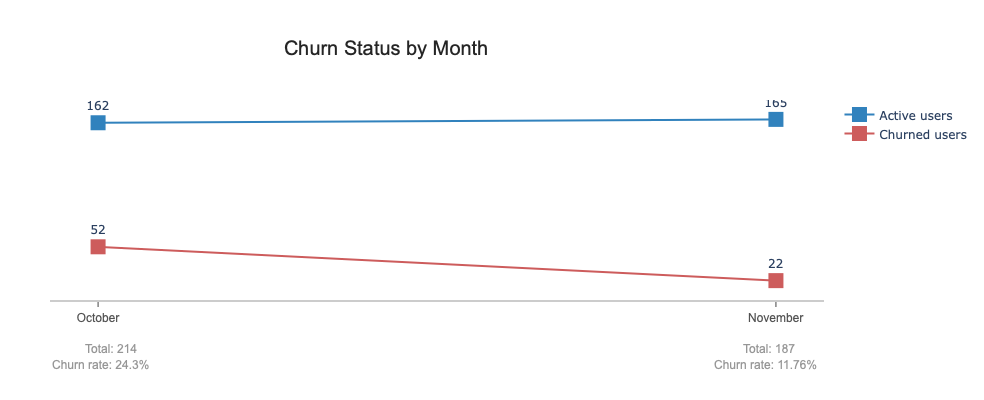

In [262]:
plot = draw_lineplot(x, y_churned, y_stayed)
plot.show()

### Does the gender affect the user churn status?

In [263]:
# calculate the number of female and male users
male = df_clean.select('userId', 'gender').where(df.gender == 'M').groupBy('userId').count().agg(count("count"))
female = df_clean.select('userId', 'gender').where(df.gender == 'F').groupBy('userId').count().agg(count("count"))

print(f'There are {male.collect()[0]["count(count)"]} male and {female.collect()[0]["count(count)"]} female users in the dataset.')


There are 121 male and 104 female users in the dataset.


In [264]:
male_churned_perc = df_clean.where((df_clean.gender == 'M') & (df_clean.churn_cancellation == 1)).groupBy('userId').count().count() / df_clean.where(df_clean.churn_cancellation == 1).groupBy('userId', 'gender').count().count() * 100
print(f'{round(male_churned_perc)}% of users who churned are male.')

62% of users who churned are male.


In [265]:
female_churned_perc = df_clean.where((df_clean.gender == 'F') & (df_clean.churn_cancellation == 1)).groupBy('userId').count().count() / df_clean.where(df_clean.churn_cancellation == 1).groupBy('userId', 'gender').count().count() * 100
print(f'{round(female_churned_perc)}% of users who churned are female.')

38% of users who churned are female.


In [266]:
male_active_perc = df_clean.where((df_clean.gender == 'M') & (df_clean.churn_cancellation == 0)).groupBy('userId').count().count() / df_clean.where(df_clean.churn_cancellation == 0).groupBy('userId', 'gender').count().count() * 100
print(f'{round(male_active_perc)}% of users who are active are male.')

51% of users who are active are male.


In [267]:
female_active_perc = df_clean.where((df_clean.gender == 'F') & (df_clean.churn_cancellation == 0)).groupBy('userId').count().count() / df_clean.where(df_clean.churn_cancellation == 0).groupBy('userId', 'gender').count().count() * 100
print(f'{round(female_active_perc)}% of users who are active are female.')

49% of users who are active are female.


In [268]:
female_users_churned_perc = df_clean.where((df_clean.gender == 'F') & (df_clean.churn_cancellation == 1)).groupBy('userId').count().count() / df_clean.where(df_clean.gender == 'F').groupBy('userId').count().count() * 100
print(f'Among female users {round(female_users_churned_perc)}% churned.')

Among female users 19% churned.


In [269]:
male_users_churned_perc = df_clean.where((df_clean.gender == 'M') & (df_clean.churn_cancellation == 1)).groupBy('userId').count().count() / df_clean.where(df_clean.gender == 'M').groupBy('userId').count().count() * 100
print(f'Among male users {round(male_users_churned_perc)}% churned.')

Among male users 26% churned.


In [270]:
num_events_female = df_clean.where(df_clean.gender == 'F').count() / df_clean.count() * 100
print(f'{round(num_events_female)}% of the events are generated by female users.')

56% of the events are generated by female users.


In [271]:
num_events_male = df_clean.where(df_clean.gender == 'M').count() / df_clean.count() * 100
print(f'{round(num_events_male)}% of the events are generated by male users.')

44% of the events are generated by male users.


In [272]:
num_events_female_churned = df_clean.where((df_clean.gender == 'F') & (df_clean.churn_cancellation == 1)).count() / df_clean.count() * 100
print(f'{round(num_events_female_churned)}% of the events are generated by female users who churned.')

7% of the events are generated by female users who churned.


In [273]:
num_events_male_churned = df_clean.where((df_clean.gender == 'M') & (df_clean.churn_cancellation == 1)).count() / df_clean.count() * 100
print(f'{round(num_events_male_churned)}% of the events are generated by male users who churned.')

9% of the events are generated by male users who churned.


In [274]:
x = ['female', 'male']
y_churned_female = df_clean.where((df_clean.gender == 'F') & (df_clean.churn_cancellation == 1)).groupBy('userId').count().count()
y_churned_male = df_clean.where((df_clean.gender == 'M') & (df_clean.churn_cancellation == 1)).groupBy('userId').count().count()
y_churned = [y_churned_female,y_churned_male]
y_stayed_female = female.collect()[0]["count(count)"] - y_churned_female
y_stayed_male = male.collect()[0]["count(count)"] - y_churned_male
y_total = [female.collect()[0]["count(count)"], male.collect()[0]["count(count)"]]
y_stayed = [y_stayed_female, y_stayed_male]

In [275]:
colors = {'churned':'indianred', 'stayed':'rgb(49,130,189)'}
labels = ['Churned users', 'Active users']


def draw_barplot_gender(x, y_churned, y_stayed):
    '''
    Draw bar plot by gender comparing churned users vs active users).
    
    inputs:
        x: gender
        y_churned: number of users churned by month
        y_stayed: number of users active by month
        
    output:
        plotly bar graph
    '''
    fig = go.Figure(data=[
        go.Bar(name='churned users', 
               x=x, 
               y=y_churned, 
               marker=dict(color=colors['churned']),
               text = [f"Churn Rate: {100*(cnt/(total+1e-10)) :.2f}%<br>" \
               for cnt,total in zip(y_churned,y_total)],
               width=0.5),
        go.Bar(name='active users', 
               x=x, 
               y=y_stayed,
               marker=dict(color=colors['stayed']),
               width=0.5)
    ])
    
    # Change the bar mode
    fig.update_layout(barmode='stack')
    
    fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=False,
    ),
    autosize=True,
    showlegend=True,
    plot_bgcolor='white'
)
    
    # Title
    annotations = []
    annotations.append(dict(xref='paper', yref='paper', x=0.3, y=1.2,
                              xanchor='left', yanchor='bottom',
                              text='Churn Status by Gender',
                              font=dict(family='Arial',
                                        size=20,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
    # Add totals
    annotations.append(dict(xref='paper', yref='paper', x=0.25, y=0.92,
                              xanchor='center', yanchor='top',
                              text=f'Total: {y_total[0]}',
                              font=dict(family='Arial',
                                        size=14,
                                        color='rgb(150,150,150)'),
                              showarrow=False))
    
    annotations.append(dict(xref='paper', yref='paper', x=0.75, y=1.07,
                              xanchor='center', yanchor='top',
                              text=f'Total: {y_total[1]}',
                              font=dict(family='Arial',
                                        size=14,
                                        color='rgb(150,150,150)'),
                              showarrow=False))
    
    fig.update_layout(annotations=annotations)
    
    return fig               

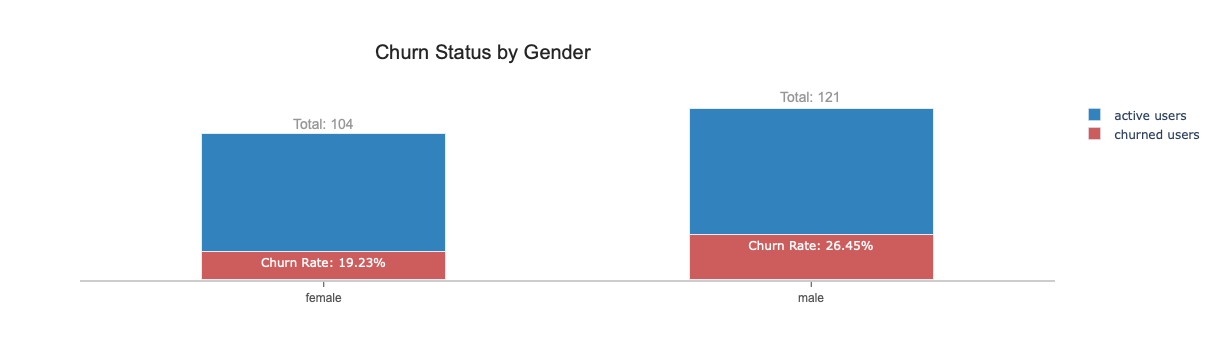

In [276]:
plot_2 = draw_barplot_gender(x, y_churned, y_stayed)
plot_2.show()

**Comparing female** and **male users** we observe that: <br>
- There are **more male users** (121) than female users (104).
- **Most of the users** who have **churned** are **male** (62%).
- Among **female** users **19% have churned**, while among **male** users **26% have churned**.
- **Female users** seem to be **more active**. They have generated **56% of the events**.
- **Female users who churned generated fewer events** than male users who churned.




### Does the subscription plan (free vs paid) affect the user churn status?

In [277]:
# calculate the number of paid and free accounts

paid = df_clean.select('userId', 'level').where(df_clean.level == 'paid').groupBy('userId').count().agg(count("count"))
free = df_clean.select('userId', 'level').where(df_clean.level == 'free').groupBy('userId').count().agg(count("count"))

print(f'There are {paid.collect()[0]["count(count)"]} paid and {free.collect()[0]["count(count)"]} free plan accounts in dataset.')

There are 165 paid and 195 free plan accounts in dataset.


The **total number of paid and free accounts exceeds the total number of unique users**. This may be due to the fact that some of them may have upgraded or downgraded the service during the time period available in the dataset.

In [278]:
paid_churned = df_clean.where((df_clean.level == 'paid') & (df_clean.churn_cancellation == 1)).groupBy('userId').count().count() / df_clean.where(df_clean.churn_cancellation == 1).groupBy('userId', 'level').count().count() * 100
print(f'{round(paid_churned)}% of churned users were on a paid plan.')

44% of churned users were on a paid plan.


In [279]:
paid_active = df_clean.where((df_clean.level == 'paid') & (df_clean.churn_cancellation == 0)).groupBy('userId').count().count() / df_clean.where(df_clean.churn_cancellation == 0).groupBy('userId', 'level').count().count() * 100
print(f'{round(paid_active)}% of active users are on a paid plan.')

46% of active users are on a paid plan.


There is **not a big difference** between **active and cancelled users** in terms of the **proportion of paid subscription plans**. Overall, there are **more free subscriptions** than paid ones.

In [280]:
num_events_paid_churned = df_clean.where((df_clean.level == 'paid') & (df_clean.churn_cancellation == 1)).count() / df_clean.count() * 100
print(f'{round(num_events_paid_churned)}% of the events (interactions) are generated by paying users who churned.')

12% of the events (interactions) are generated by paying users who churned.


In [281]:
num_events_free_churned = df_clean.where((df_clean.level == 'free') & (df_clean.churn_cancellation == 1)).count() / df_clean.count() * 100
print(f'{round(num_events_free_churned)}% of the events (interactions) are generated by users with a free subscription who churned.')

4% of the events (interactions) are generated by users with a free subscription who churned.


In [282]:
num_events_paid_active = df_clean.where((df_clean.level == 'paid') & (df_clean.churn_cancellation == 0)).count() / df_clean.count() * 100
print(f'{round(num_events_paid_active)}% of the events (interactions) are generated by paying active users.')

68% of the events (interactions) are generated by paying active users.


In [283]:
num_events_free_active = df_clean.where((df_clean.level == 'free') & (df_clean.churn_cancellation == 0)).count() / df_clean.count() * 100
print(f'{round(num_events_free_active)}% of the events (interactions) are generated by active users with a free subscription.')

16% of the events (interactions) are generated by active users with a free subscription.


From the above we see that **users who paid for their subscription** are **more active** than those using the free plan, for active users and those who churned.

### Explore interactions (events), sessions, days since registration

In [284]:
# Check the average number of events/interactions per user

avg_interactions_churned = df_clean.where(df_clean.churn_cancellation == 1).count() /  df_clean.where(df_clean.churn_cancellation == 1).groupBy('userId').count().count()
avg_interactions_active = df_clean.where(df_clean.churn_cancellation == 0).count() / df_clean.where(df_clean.churn_cancellation == 0).groupBy('userId').count().count()

print(f'Average number of interactions (events) for churned users:{round(avg_interactions_churned)}') 
print(f'Average number of interactions (events) for active users:{round(avg_interactions_active)}')
print(' ')

Average number of interactions (events) for churned users:863
Average number of interactions (events) for active users:1348
 


In [285]:
# Check the average number of sessions per user

avg_sessions_churned = df_clean.where(df_clean.churn_cancellation == 1).groupBy('userId', 'sessionId').count().count() / df_clean.where(df_clean.churn_cancellation == 1).groupBy('userId').count().count()
avg_sessions_active = df_clean.where(df_clean.churn_cancellation == 0).groupBy('userId', 'sessionId').count().count() / df_clean.where(df_clean.churn_cancellation == 0).groupBy('userId').count().count()

print(f'Average number of sessions for churned users:{round(avg_sessions_churned)}') 
print(f'Average number of sessions for active users:{round(avg_sessions_active)}')
print(' ')

Average number of sessions for churned users:10
Average number of sessions for active users:15
 


In [286]:
# Check the average number of of items per session per user

avg_items_session_churned = df_clean.where(df_clean.churn_cancellation == 1).count() / df_clean.where(df_clean.churn_cancellation == 1).groupBy('userId', 'sessionId').count().count()
avg_items_session_active = df_clean.where(df_clean.churn_cancellation == 0).count() / df_clean.where(df_clean.churn_cancellation == 0).groupBy('userId', 'sessionId').count().count()

print(f'Average number of items in a session for churned users:{round(avg_items_session_churned)}') 
print(f'Average number of items in a session for active users:{round(avg_items_session_active)}')
print(' ')

Average number of items in a session for churned users:84
Average number of items in a session for active users:88
 


In [287]:
# Check the average session lenght per user

# create dataframe with first timestamp (ts_date) per session
# add column 'churn' and set as 1 for rows with churned user
df_min_ts = df_clean.groupBy('userId', 'sessionId').agg(min('ts_date').alias('min_ts'))
df_min_ts = df_min_ts.withColumn('churn', when((df_min_ts.userId).isin(cancelled_users), 1).otherwise(0))

# create dataframe with last timestamp (ts_date) per session
df_max_ts = df_clean.groupBy('userId', 'sessionId').agg(max('ts_date').alias('max_ts'))

# join dataframes
df_ts_session = df_min_ts.join(df_max_ts, on=['userId', 'sessionId'])

# apply udf when calculating and creating new column with time difference (hours)
df_ts_session = df_ts_session.withColumn('session_length', ((unix_timestamp(df_ts_session['max_ts']) - unix_timestamp(df_ts_session['min_ts'])) / 3600).cast('float'))


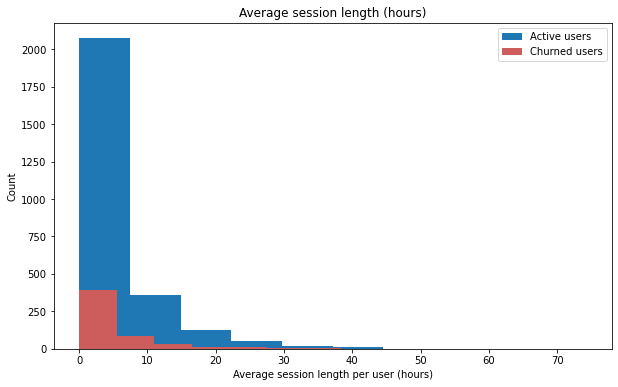

In [288]:
# plot results

plt.figure(figsize=(10,6))
plt.hist(df_ts_session.where(df_ts_session['churn'] == 0).select('session_length').toPandas(), label='Active users', color='tab:blue')
plt.hist(df_ts_session.where(df_ts_session['churn'] == 1).select('session_length').toPandas(), label='Churned users', color='indianred')
plt.legend(loc='upper right')
plt.title('Average session length (hours)')
plt.xlabel('Average session length per user (hours)')
plt.ylabel('Count')
plt.show()

In [289]:
# average session length for churned users
print('Average session length for churned users (hours):')
df_ts_session.where(df_ts_session.churn == 1).agg(avg('session_length')).show()

# average session length for active users
print('Average session length for active users (hours):')
df_ts_session.where(df_ts_session.churn == 0).agg(avg('session_length')).show()

Average session length for churned users (hours):


+-------------------+
|avg(session_length)|
+-------------------+
|  4.718692338992486|
+-------------------+

Average session length for active users (hours):


+-------------------+
|avg(session_length)|
+-------------------+
| 5.0479682968478485|
+-------------------+



In [290]:
# Check the average registration/usage length per user (days from registration date to ts for latest event)

# Create dataframe with last timestamp (ts_date) per user
df_last_ts = df_clean.groupBy('userId').agg(max('ts_date').alias('last_interaction'))

# Join dataframes and add column 'days_registered' with number of days from registration date to ts for last event
df_registration_last_ts = df_last_ts.join(df_clean, on='userId').select(df_last_ts['*'], df_clean['registration_date'], df_clean['churn_cancellation']).withColumn('days_registered', datediff(df_last_ts['last_interaction'], df_clean['registration_date']).cast('float'))

# Store columns to be used as pandas dataframe
df_registration_last_ts_pd = df_registration_last_ts.select('userId','churn_cancellation', 'days_registered').toPandas()

# Collapse rows by user and churn status
df_registration_last_ts_pd = df_registration_last_ts_pd.groupby(['userId','churn_cancellation']).mean().reset_index()

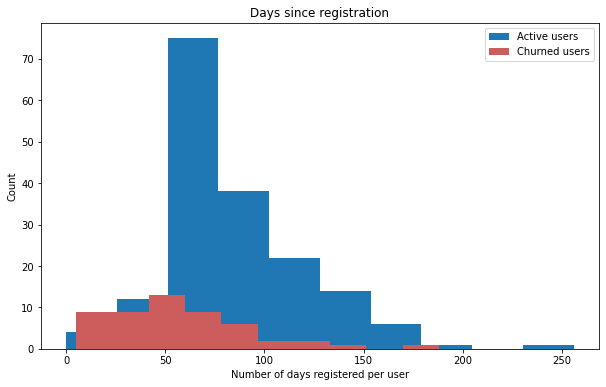

In [291]:
# plot results

plt.figure(figsize=(10,6))
plt.hist(df_registration_last_ts_pd[df_registration_last_ts_pd['churn_cancellation'] == 0]['days_registered'], label='Active users', color='tab:blue')
plt.hist(df_registration_last_ts_pd[df_registration_last_ts_pd['churn_cancellation'] == 1]['days_registered'], label='Churned users', color='indianred')
plt.legend(loc='upper right')
plt.title('Days since registration')
plt.xlabel('Number of days registered per user')
plt.ylabel('Count')
plt.show()

In [292]:
# Get the average number of days since registration for churned users
avg_days_reg_churned = df_registration_last_ts_pd[df_registration_last_ts_pd['churn_cancellation'] == 1]['days_registered'].mean()
print(f'Average number of days since registration for churned users: {avg_days_reg_churned}')

# Get average number of days since registration for active users
avg_days_reg_active = df_registration_last_ts_pd[df_registration_last_ts_pd['churn_cancellation'] == 0]['days_registered'].mean()
print(f'Average number of days since registration for active users: {avg_days_reg_active}')

Average number of days since registration for churned users: 57.28845977783203
Average number of days since registration for active users: 86.58381652832031


On average, it seems that: <br>
- **Active users interact more with the platform** and **spend more time on it** than churned users. 
- **Active users have been registered onto the platform for a longer time** than churned users. 

#### Average number of unique artists and songs played per user

In [293]:
avg_art_per_user_churned = df_clean.where(df_clean.churn_cancellation == 1).groupBy('artist').count().count() / df_clean.where(
    df_clean.churn_cancellation == 1).groupBy('userId').count().count()
print(f'Average number of unique artists played per churned user: {avg_art_per_user_churned}')

Average number of unique artists played per churned user: 161.59615384615384


In [294]:
avg_art_per_user_active = df_clean.where(df_clean.churn_cancellation == 0).groupBy('artist').count().count() / df_clean.where(
    df_clean.churn_cancellation == 0).groupBy('userId').count().count()
print(f'Average number of unique artists played per active user: {avg_art_per_user_active}')

Average number of unique artists played per active user: 96.26011560693641


In [295]:
avg_songs_per_user_churned = df_clean.where(df_clean.churn_cancellation == 1).groupBy('song').count().count() / df_clean.where(
    df_clean.churn_cancellation == 1).groupBy('userId').count().count()
print(f'Average number of unique songs played per churned user: {avg_songs_per_user_churned}')

Average number of unique songs played per churned user: 369.5576923076923


In [296]:
avg_songs_per_user_active = df_clean.where(df_clean.churn_cancellation == 0).groupBy('song').count().count() / df_clean.where(
    df_clean.churn_cancellation == 0).groupBy('userId').count().count()
print(f'Average number of unique songs played per active user: {avg_songs_per_user_active}')

Average number of unique songs played per active user: 308.3063583815029


#### Average number of unique artists and songs played per session

In [297]:
avg_art_per_session_churned = df_clean.where(df_clean.churn_cancellation == 1).groupBy('artist').count().count() / df_clean.where(
    df_clean.churn_cancellation == 1).groupBy('userId', 'sessionId').count().count()
print(f'Average number of unique artists played per session/churned user: {avg_art_per_session_churned}')

Average number of unique artists played per session/churned user: 15.64804469273743


In [298]:
avg_art_per_session_active = df_clean.where(df_clean.churn_cancellation == 0).groupBy('artist').count().count() / df_clean.where(
    df_clean.churn_cancellation == 0).groupBy('userId', 'sessionId').count().count()
print(f'Average number of unique artists played per session/active user: {avg_art_per_session_active}')

Average number of unique artists played per session/active user: 6.310344827586207


In [299]:
avg_songs_per_session_churned = df_clean.where(df_clean.churn_cancellation == 1).groupBy('song').count().count() / df_clean.where(
    df_clean.churn_cancellation == 1).groupBy('userId', 'sessionId').count().count()
print(f'Average number of unique songs played per session/churned user: {avg_songs_per_session_churned}')

Average number of unique songs played per session/churned user: 35.78584729981378


In [300]:
avg_songs_per_session_active = df_clean.where(df_clean.churn_cancellation == 0).groupBy('song').count().count() / df_clean.where(
    df_clean.churn_cancellation == 0).groupBy('userId', 'sessionId').count().count()
print(f'Average number of unique songs played per session/active user: {avg_songs_per_session_active}')

Average number of unique songs played per session/active user: 20.211064797271693


#### Average number of songs played per user

In [301]:
avg_songs_churned = df_clean.where((df_clean.page == 'NextSong') & (df_clean.churn_cancellation == 1)).count() / df_clean.where(df_clean.churn_cancellation == 1).groupBy('userId').count().count()
print(f'Average number of songs played per churned users: {avg_songs_churned}')

Average number of songs played per churned users: 699.8846153846154


In [302]:
avg_songs_active = df_clean.where((df_clean.page == 'NextSong') & (df_clean.churn_cancellation == 0)).count() / df_clean.where(df_clean.churn_cancellation == 0).groupBy('userId').count().count()
print(f'Average number of songs played per active users: {avg_songs_active}')

Average number of songs played per active users: 1108.1734104046243


#### Average number of songs played per user per day

In [303]:
avg_songs_churned_perday = df_clean.where((df_clean.page == 'NextSong') & (df_clean.churn_cancellation == 1)).count() / df_clean.where(df_clean.churn_cancellation == 1).groupBy('userId','ts_date').count().count()
print(f'Average number of songs played per churned users per day: {avg_songs_churned_perday}')

Average number of songs played per churned users per day: 0.8136737614022537


In [304]:
avg_songs_active_perday = df_clean.where((df_clean.page == 'NextSong') & (df_clean.churn_cancellation == 0)).count() / df_clean.where(df_clean.churn_cancellation == 0).groupBy('userId','ts_date').count().count()
print(f'Average number of songs played per active users per day: {avg_songs_active_perday}')

Average number of songs played per active users per day: 0.8239349151843082


Interestingly, **users who have churned have listened to more different artists and songs on average** than active users, while the latter are more active in terms of total songs played. It may be that churned users explore the service more.

### Explore visits distribution per page by user

In [305]:
# Convert dataframe to pandas dataframe
df_clean_pandas = df_clean.toPandas()

In [306]:
# Distribution of events through page visited
df_clean_pandas.page.value_counts()

NextSong                     228108
Thumbs Up                     12551
Home                          10082
Add to Playlist                6526
Add Friend                     4277
Roll Advert                    3933
Logout                         3226
Thumbs Down                    2546
Downgrade                      2055
Settings                       1514
Help                           1454
Upgrade                         499
About                           495
Save Settings                   310
Error                           252
Submit Upgrade                  159
Submit Downgrade                 63
Cancellation Confirmation        52
Cancel                           52
Name: page, dtype: int64

In [307]:
# Create a filter with rows that have the value 'Cancel' in column 'page'
filter_page_cancel = df_clean_pandas.loc[df_clean_pandas['page'] == 'Cancel'].index

# Use the filter to select rows before the event 'Cancel'
df_clean_pandas.iloc[filter_page_cancel-1].page.value_counts(ascending=False)

NextSong       36
Roll Advert     4
Settings        4
Downgrade       2
Thumbs Up       2
Add Friend      1
Error           1
Home            1
Thumbs Down     1
Name: page, dtype: int64

- **The most popular action is 'NextSong'** as expected for a music streaming service.
- Before visiting the 'Cancel' page, the majority of churned users tapped 'NextSong'.

In [308]:
df_pages = df_clean.groupBy('userId', 'page', 'churn_cancellation').count().toPandas()
df_pages = df_pages.rename(columns={'count': 'visits'})

In [309]:
y_churned = df_pages[df_pages.churn_cancellation ==1][['page','visits']]
y_stayed = df_pages[df_pages.churn_cancellation ==0][['page','visits']]

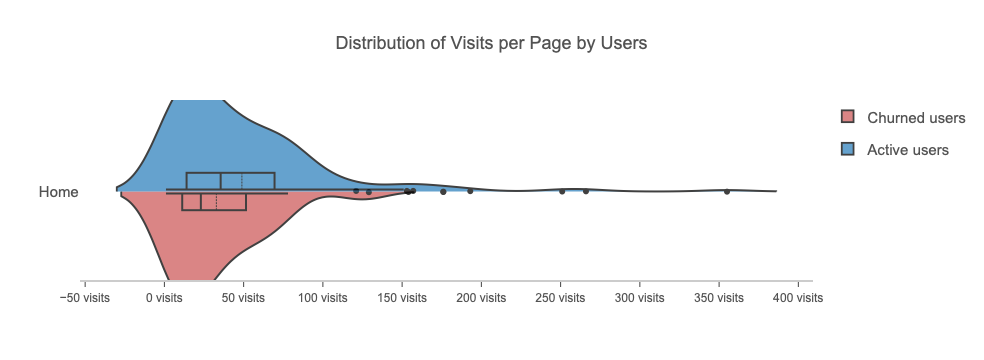

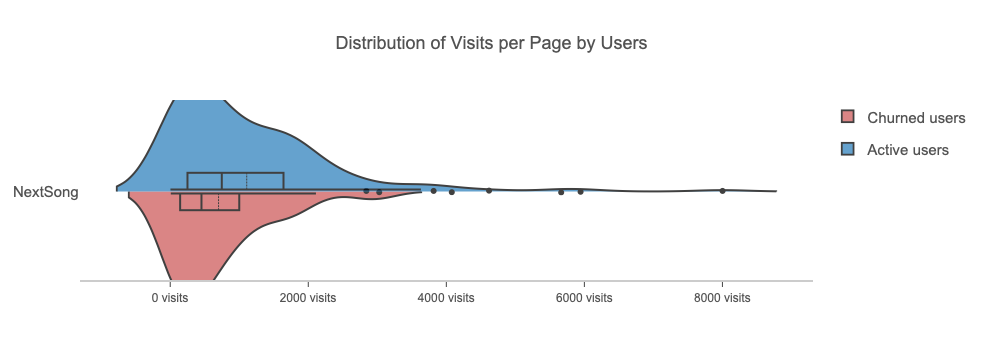

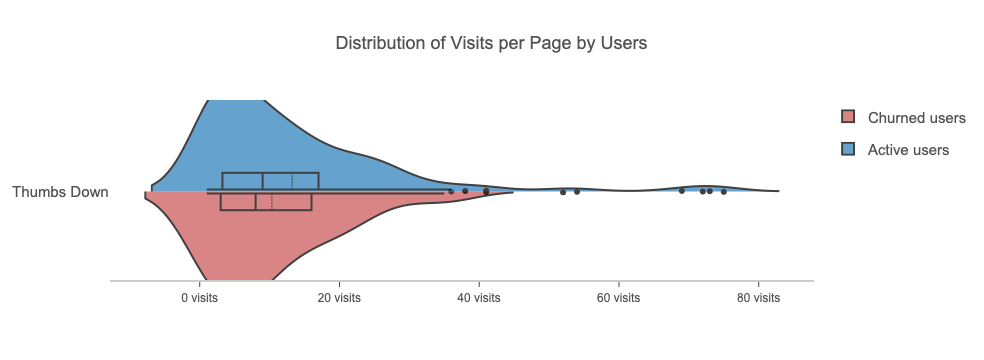

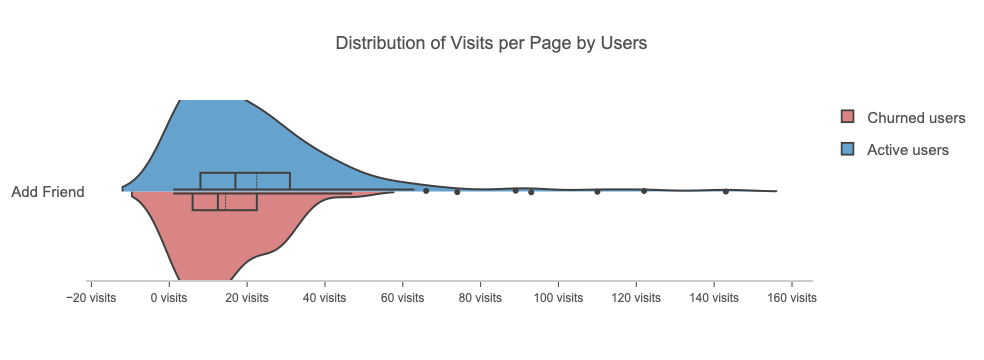

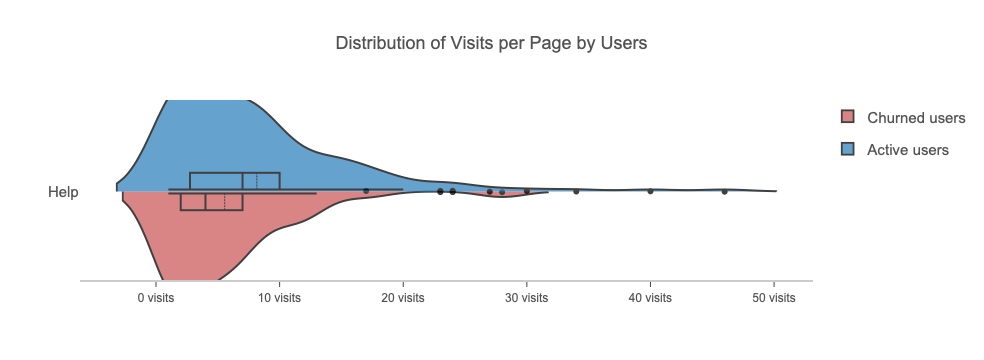

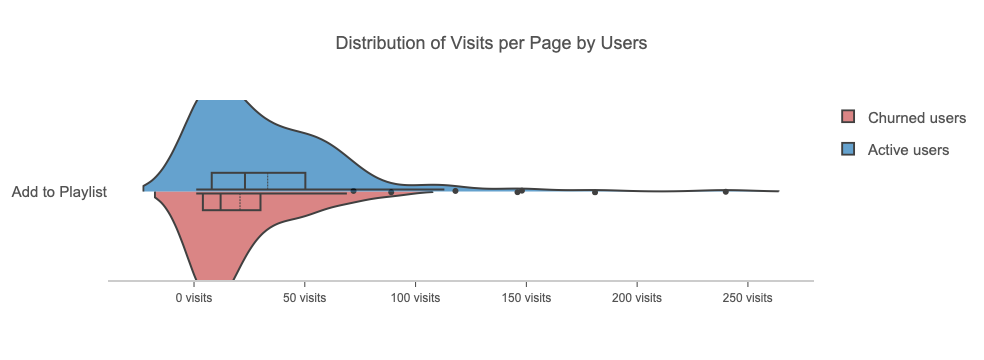

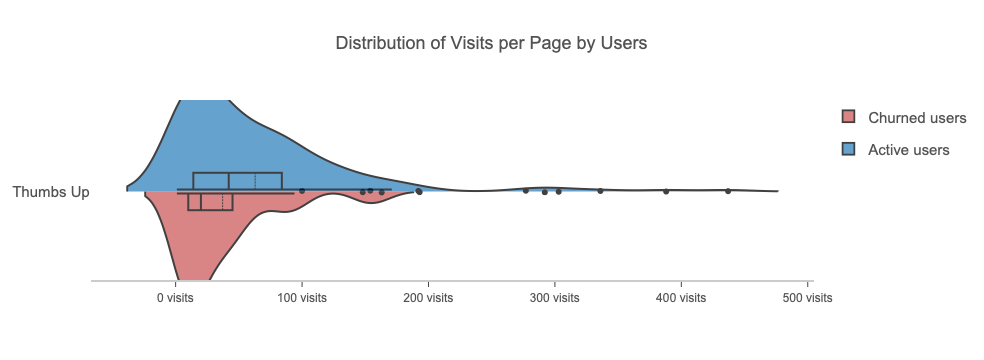

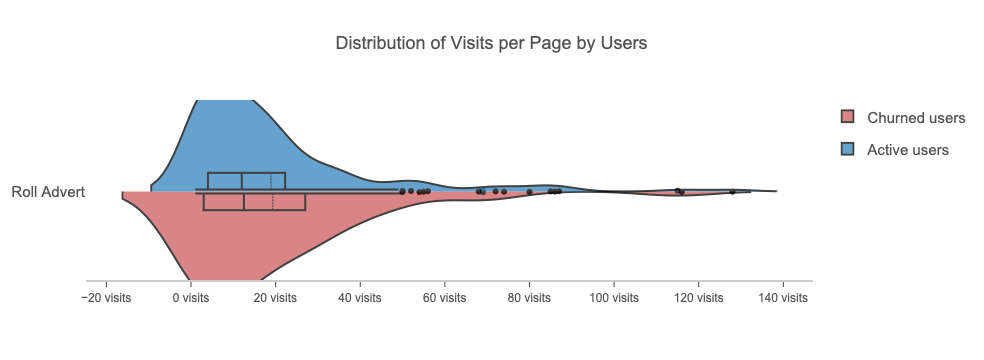

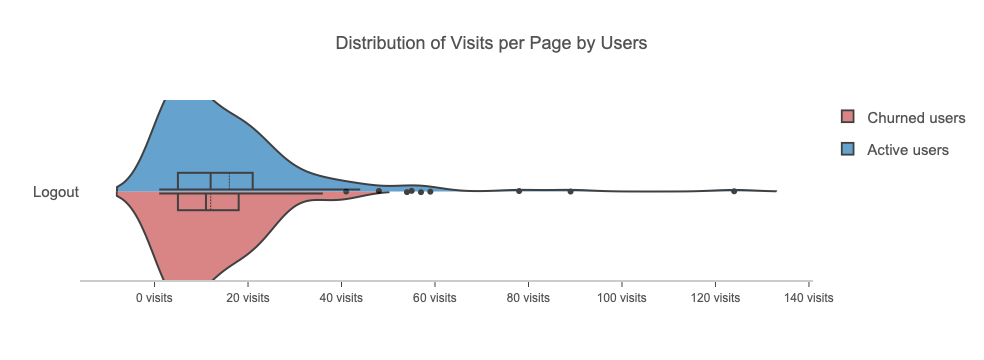

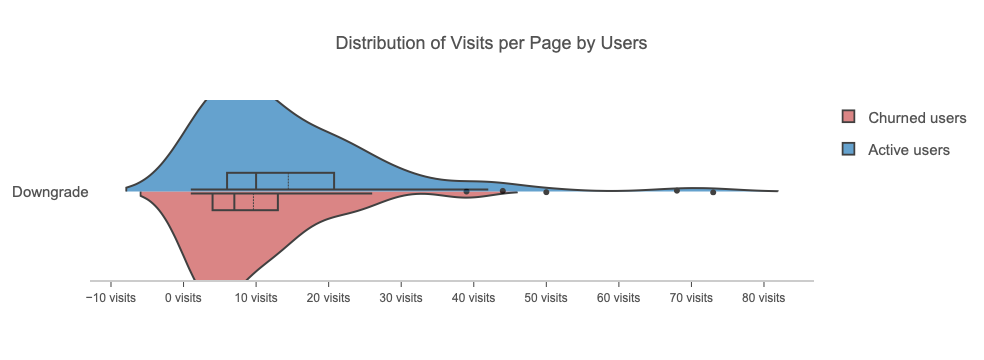

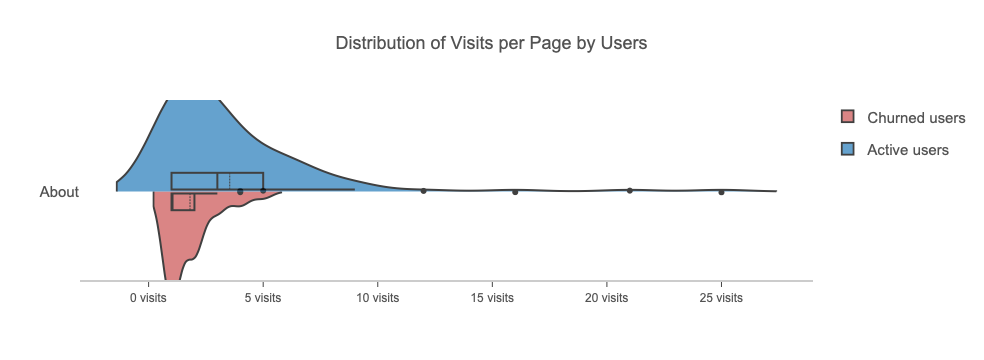

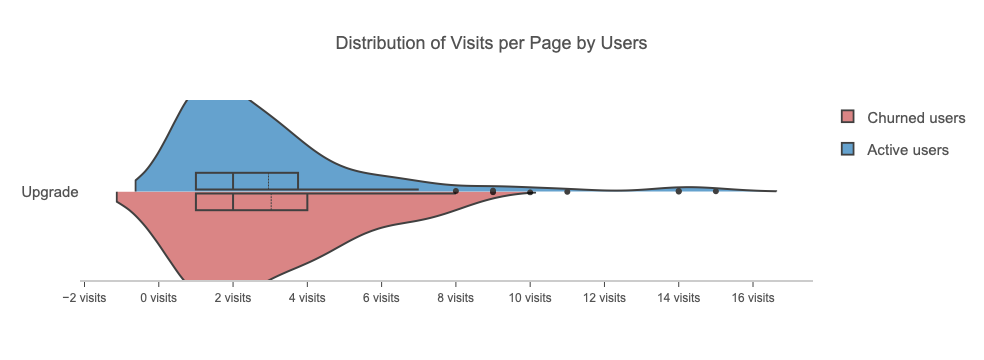

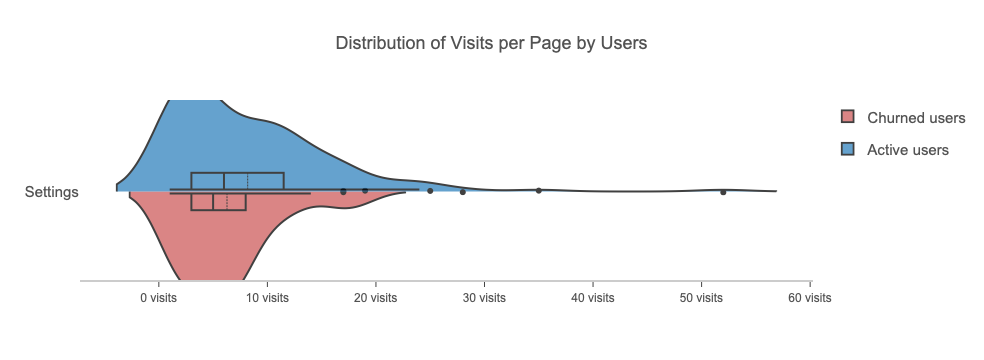

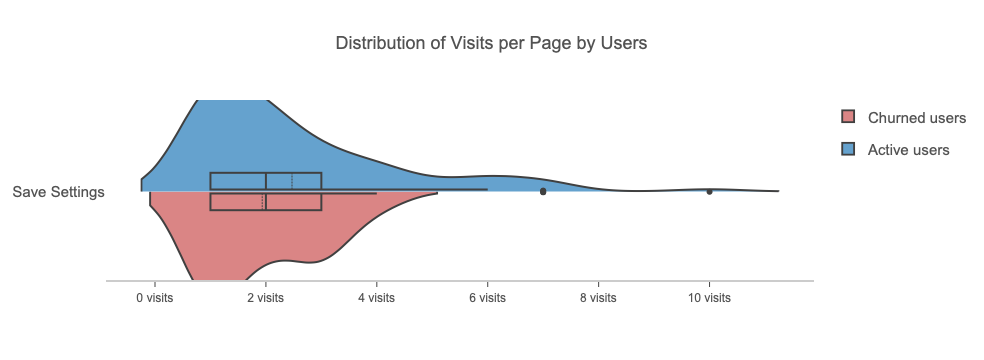

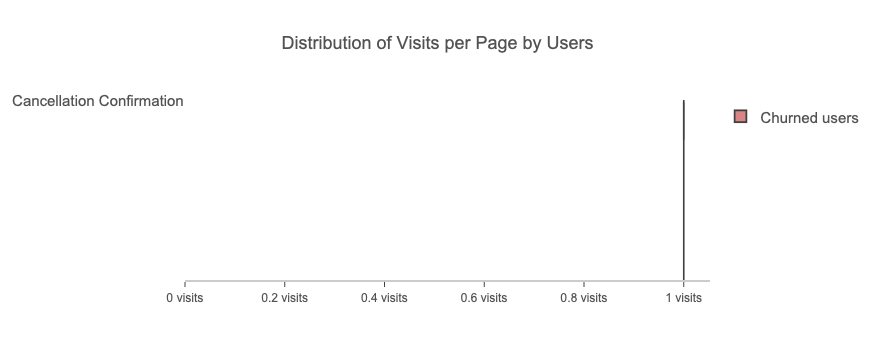

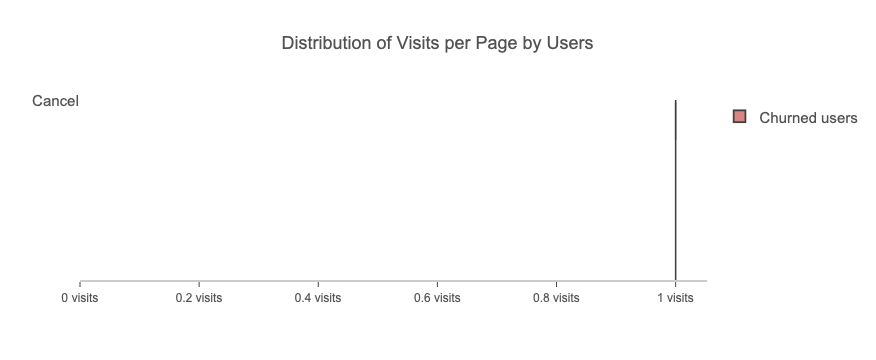

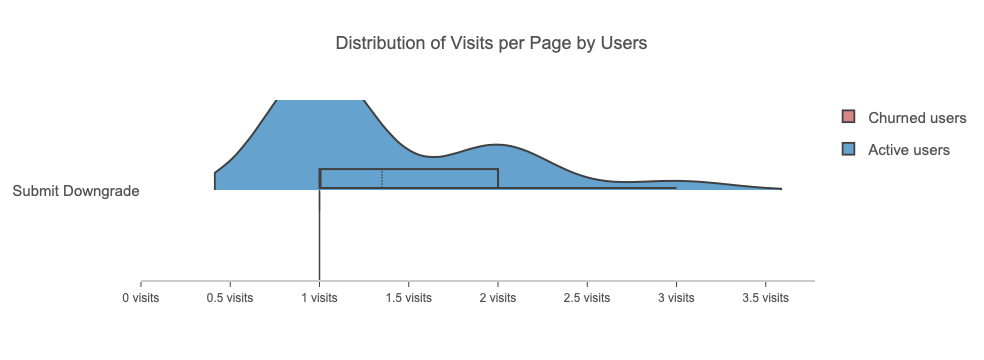

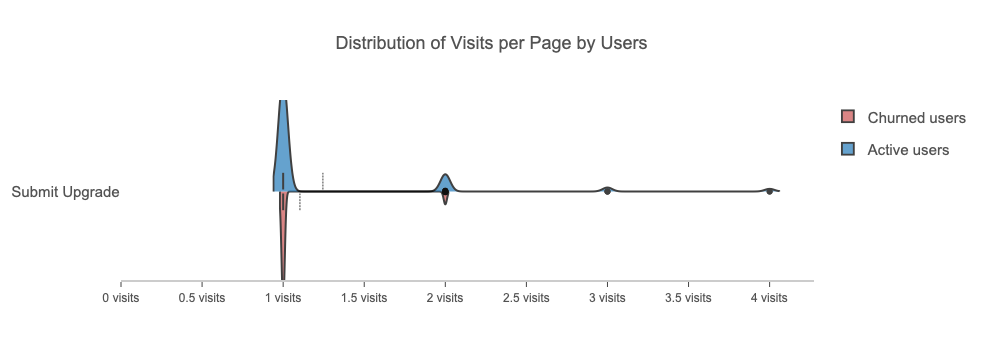

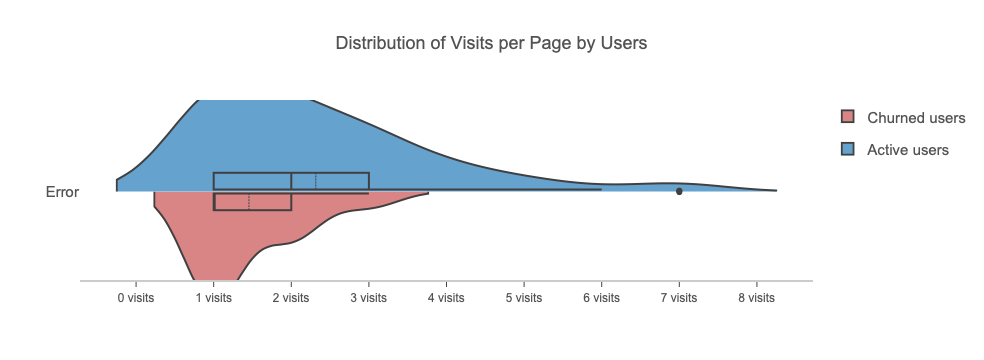

In [310]:
# Draw violins plot to compare the distributions of visits per page by user

colors = {'churned':'indianred', 'stayed':'rgb(49,130,189)'}
labels = ['Churned users', 'Active users']
pages = list(df_pages.page.unique())

    
for page in pages:

    fig = go.Figure()

    fig.add_trace(go.Violin(x=y_churned[y_churned.page == page]['visits'],
                    y=y_churned[y_churned.page == page]['page'],
                    box_visible=True, line_color='black',
                    fillcolor=colors['churned'], opacity=0.6, 
                    name=labels[0], scalegroup='Churned', legendgroup='Churned',
                    side = 'negative')
         )
    fig.add_trace(go.Violin(x=y_stayed[y_stayed.page == page]['visits'],
                            y=y_stayed[y_stayed.page == page]['page'],
                            box_visible=True, line_color='black',
                            fillcolor=colors['stayed'], opacity=0.6, 
                            name=labels[1], scalegroup='Active', legendgroup='Active',
                            side = 'positive')
                 )

    trace_all = dict(
         box_visible=True,
         box_width=0.3,
         meanline_visible=True,
         meanline_width=1,
         opacity=0.75,
         jitter=0.01,
         orientation='h'
    )

    fig.update_traces(trace_all)


    fig.update_layout(violinmode='overlay', violingap=0,
                     title = dict(
                             text='Distribution of Visits per Page by Users',
                             x=0.5, 
                             y=0.9,
                             xanchor='center',
                             yanchor='top', 
                             font_size=18, 
                             ),
                     xaxis=dict(ticksuffix=' visits',rangemode='tozero',
                                showline=True,
                                 showgrid=False,
                                 showticklabels=True,
                                 linecolor='rgb(204, 204, 204)',
                                 linewidth=2,
                                 ticks='outside',
                                 tickfont=dict(
                                             family='Arial',
                                             size=12,
                                             color='rgb(82, 82, 82)')),
                     showlegend = True,
                     plot_bgcolor = 'white', 
                     paper_bgcolor = 'white',
                     font = dict(
                             family='Arial', 
                             size=15,
                         color='rgb(82, 82, 82)'
                     )
                    )
    fig.update_yaxes(automargin=True)
    fig.update_xaxes(automargin=True)

    fig.show()
        

 

#### Average number of thumbs up per user

In [311]:
avg_thumbsup_churned = df_clean.where((df_clean.page == 'Thumbs Up') & (df_clean.churn_cancellation == 1)).count() / df_clean.where(df_clean.churn_cancellation == 1).groupBy('userId').count().count()
print(f'Average number of thumbs up for churned users: {avg_thumbsup_churned}')

Average number of thumbs up for churned users: 35.75


In [312]:
avg_thumbsup_active = df_clean.where((df_clean.page == 'Thumbs Up') & (df_clean.churn_cancellation == 0)).count() / df_clean.where(df_clean.churn_cancellation == 0).groupBy('userId').count().count()
print(f'Average number of thumbs up for active users: {avg_thumbsup_active}')

Average number of thumbs up for active users: 61.80346820809248


#### Average number of thumbs down per user

In [313]:
avg_thumbsdown_churned = df_clean.where((df_clean.page == 'Thumbs Down') & (df_clean.churn_cancellation == 1)).count() / df_clean.where(df_clean.churn_cancellation == 1).groupBy('userId').count().count()
print(f'Average number of thumbs down for churned users: {avg_thumbsdown_churned}')

Average number of thumbs down for churned users: 9.538461538461538


In [314]:
avg_thumbsdown_active = df_clean.where((df_clean.page == 'Thumbs Down') & (df_clean.churn_cancellation == 0)).count() / df_clean.where(df_clean.churn_cancellation == 0).groupBy('userId').count().count()
print(f'Average number of thumbs down for active users: {avg_thumbsdown_active}')

Average number of thumbs down for active users: 11.84971098265896


#### Average number of 'add to playlist'

In [315]:
avg_addplaylist_churned = df_clean.where((df_clean.page == 'Add to Playlist') & (df_clean.churn_cancellation == 1)).count() / df_clean.where(df_clean.churn_cancellation == 1).groupBy('userId').count().count()
print(f'Average number of time add to playlist for churned users: {avg_addplaylist_churned}')

Average number of time add to playlist for churned users: 19.96153846153846


In [316]:
avg_addplaylist_active = df_clean.where((df_clean.page == 'Add to Playlist') & (df_clean.churn_cancellation == 0)).count() / df_clean.where(df_clean.churn_cancellation == 0).groupBy('userId').count().count()
print(f'Average number of time add to playlist for active users: {avg_addplaylist_active}')

Average number of time add to playlist for active users: 31.722543352601157


#### Average number of 'add friend'

In [317]:
avg_addfriend_churned = df_clean.where((df_clean.page == 'Add Friend') & (df_clean.churn_cancellation == 1)).count() / df_clean.where(df_clean.churn_cancellation == 1).groupBy('userId').count().count()
print(f'Average number of time add friend for churned users: {avg_addfriend_churned}')

Average number of time add friend for churned users: 12.23076923076923


In [318]:
avg_addfriend_active = df_clean.where((df_clean.page == 'Add Friend') & (df_clean.churn_cancellation == 0)).count() / df_clean.where(df_clean.churn_cancellation == 0).groupBy('userId').count().count()
print(f'Average number of time add friend for active users: {avg_addfriend_active}')

Average number of time add friend for active users: 21.046242774566473


On average, **active users** give more thumbs up and thumbs down, add more songs to the playlist, and add more friends to the platform than users who cancelled, confirming their **higher engagement with the platform**.

### Does user location affect churn status?

In [319]:
df_location = df_clean.select('userId','churn_cancellation', 'city','last_city', 'state', 'last_state').toPandas()
df_location_pd = df_location.groupby(['userId','last_city', 'last_state']).mean().reset_index()

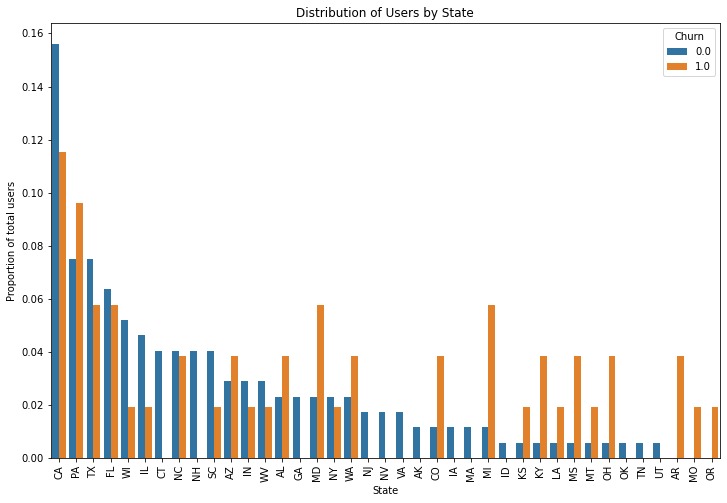

In [320]:
# Plot distribution of users by state
plt.figure(figsize=(12,8))

x, y, hue = 'last_state', 'proportion', 'churn_cancellation'
hue_order = ['Active users', 'Churned users']

(df_location_pd[x]
 .groupby(df_location_pd[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, 'data'), x=x, y=y, hue=hue))

plt.legend(loc='upper right', title='Churn')
plt.title('Distribution of Users by State')
plt.xlabel('State')
plt.ylabel('Proportion of total users')
plt.xticks(rotation=90)
plt.show()

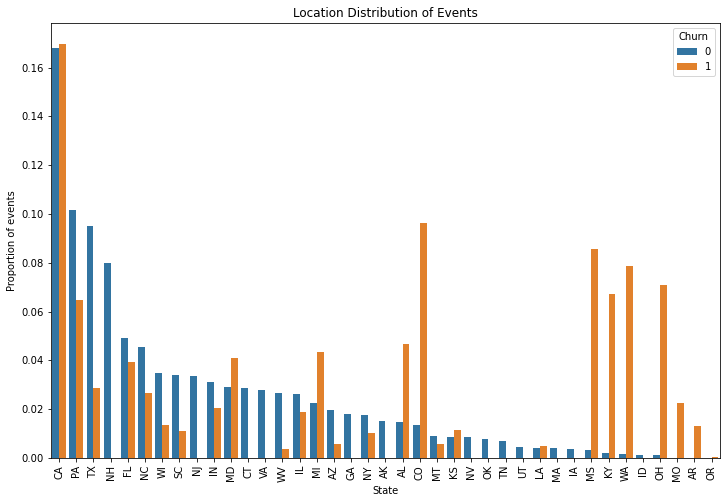

In [321]:
# Plot distribution of events by state
plt.figure(figsize=(12,8))

x, y, hue = 'state', 'proportion', 'churn_cancellation'
hue_order = ['Active users', 'Churned users']

(df_location[x]
 .groupby(df_location[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, 'data'), x=x, y=y, hue=hue))

plt.legend(loc='upper right', title='Churn')
plt.title('Location Distribution of Events')
plt.xlabel('State')
plt.ylabel('Proportion of events')
plt.xticks(rotation=90)
plt.show()

- Overall, **there appear to be differences in the distribution of active and churned users across states**. In addition, there are some states that have no churned users (e.g., Connecticut and New Hampshire), and some states that have only churned users (e.g., Arkansas, Missouri, Oregon).
- **California, Pennsylvania, Texas, Florida have the most users and events** for active and churned users.

[Back to TOC](#Table-of-Contents:) 
<a class="anchor" id='chapter4'></a>

# Feature Engineering

To predict whether the user is going to churn for each user we will extract the following features:
- **Gender**: EDA showed that male and female users may have a different behavior.
- **Days since registration**: from EDA it appears that active users have been registered onto the platform for a longer time than churned users.
- **Last state**: state in which the most recent session is recorded.
- **Average songs played per day**: to see how much the user is active on the platform.
- **Last level**: the most recent user subscription plan.
- **Thumbs up proportion** (ratio thumbs up over thumbs down): to see the level of appreciation.
- **Number of add a friend events**: to see the level of engagement.
- **Average roll adverts per day**

In [9]:
def clean_data(df):
    '''
    Function that performs data cleaning of Sparkify dataset.
    
    INPUT: 
    df - pyspark dataframe containing Sparkify events
    
    OUTPUT:
    df_new - pyspark dataframe with removed rows with empty 'userId' column and duplicates if any
    '''
    
    # remove rows where userId is empty and duplicated rows
    df_clean = df.filter(df["userId"] != "").dropDuplicates()

    return df_clean


def get_date_from_timestamp(df, col_name, new_col_name):
    '''
    Function that convert timestamp to date
    '''
    
    return df.withColumn(new_col_name, F.to_timestamp(F.col(col_name) / 1000).astype(StringType()))


def prepare_dataset(df):
    '''
    Function for preparation of dataset for machine learning models.
    
    INPUT:
    df - initial dataset loaded from json file
    
    OUTPUT:
    df_ml - new dataset prepared for machine learning which
    contains the following columns:
    
    1. userId - initial id of the user
    2. gender - user's gender
    3. days_registered - days since user's registration
    4. last_state - current state of the user
    5. avg_songs_per_day - average songs played per day
    6. last_level - current subscription plan
    7. Thumbsup_proportion - ratio of thumbs up over thumbs down
    8. num_add_friends - number of add friends events
    9. avg_roll_adv_per_day - average number of roll adv played per day
    10. churn_cancellation
    '''
    
    # Clean dataset using clean_data function
    df = clean_data(df)
    
    # Convert event timestamp
    df = get_date_from_timestamp(df, 'ts', 'ts_date')
    
    # Convert registration timestamp
    df = get_date_from_timestamp(df, 'registration', 'registration_date')
    
    # Create column Churn when the event recorded is 'Cancellation Confirmation'. 
    # A value equal to 1 indicates that the user cancelled the subscription.
    churn_cancellation = udf(lambda x: 1 if x=="Cancellation Confirmation" else 0, IntegerType())
    
    df = df.withColumn("churn_cancellation", churn_cancellation("page"))
    
    # Get userId with churn_cancellation == 1
    cancelled_users = df.select(['userId']).where(df.churn_cancellation == 1).groupby('userId').count().toPandas()['userId'].values
    cancelled_users = list(cancelled_users)
    df = df.withColumn('churn_cancellation', when((df.userId).isin(cancelled_users), 1).otherwise(0))
    
    # Convert column gender to numeric: 1 for 'female' and 0 for 'male'
    gender = udf(lambda x: 1 if x=="F" else 0, IntegerType())
    
    df = df.withColumn("gender", gender("gender"))
    
    # Convert column level to numeric: 1 for 'paid' and 0 for 'free'
    level = udf(lambda x: 1 if x=="paid" else 0, IntegerType())
    
    #df = df.withColumn("level", level("level"))
    
    levels = df.select(['userId', 'level', 'ts_date'])\
                        .orderBy(desc('ts_date'))\
                        .dropDuplicates(['userId'])\
                        .select(['userId', 'level'])\
                        .withColumn('last_level', level('level').cast(IntegerType()))
    levels = levels.drop('level')
    levels = levels.withColumnRenamed('userId', 'level_userId')

    
    # Compute active days as number of days since registration
    # Create dataframe with last timestamp (ts_date) per user
    df_last_ts = df.groupBy('userId').agg(max('ts_date').alias('last_interaction'))
    
    # Join dataframes and add column 'days_registered' with number of days from registration date to ts for last event
    df = df.join(df_last_ts, on='userId').select(df_last_ts['*'], df['*']).withColumn('days_registered', datediff(df_last_ts['last_interaction'], df['registration_date']).cast('float'))
    
    # Create a new column 'date' with format 'yyyy-MM-dd'
    df = df.withColumn('date', date_format('ts_date', 'yyyy-MM-dd').alias('date'))
    
    # Create a new column 'last_state' where the last session was recorded
    df = df.withColumn("state", substring(df.location, -2, 2))
    df = df.withColumn('last_state', when(df_last_ts.last_interaction == df.ts_date, df.state))
        
    # Compute average songs played by day per user
    w = Window.partitionBy('userId', 'date')
    songs = df.where(df.page == 'NextSong').select('userId', 'date', count('userId').over(w).alias('songs')).distinct()
    w = Window.partitionBy('userId')
    songs = songs.withColumn('avg_songs_per_day', avg('songs').over(w))
    songs = songs.select(songs['userId'].alias('songs_userId'), 'avg_songs_per_day')
    songs = songs.withColumn('avg_songs_per_day', F.round(songs['avg_songs_per_day'],2)).distinct()
    
    # Compute the number of thumbs up for user
    w = Window.partitionBy('userId')
    thumbs_up = df.where(df.page == 'Thumbs Up').select('userId', count('userId').over(w).alias('thumbs_up')).distinct()
    thumbs_up = thumbs_up.select(thumbs_up['userId'].alias('thumbsup_userId'), 'thumbs_up')
 
    # Compute the number of thumbs down per user
    w = Window.partitionBy('userId')
    thumbs_down = df.where(df.page == 'Thumbs Down').select('userId', count('userId').over(w).alias('thumbs_down')).distinct()
    thumbs_down = thumbs_down.select(thumbs_down['userId'].alias('thumbsdown_userId'), 'thumbs_down')
      
    # Compute the number of add friend events per user
    w = Window.partitionBy('userId')
    num_add_friend = df.where(df.page == 'Add Friend').select('userId', count('userId').over(w).alias('num_add_friend')).distinct()
    num_add_friend = num_add_friend.select(num_add_friend['userId'].alias('friends_userId'), 'num_add_friend')
    
    # Compute the fraction of page 'roll advert'
    w = Window.partitionBy('userId', 'date')
    roll_adv = df.where(df.page == 'Roll Advert').select('userId', 'date', count('userId').over(w).alias('roll_adv')).distinct()
    w = Window.partitionBy('userId')
    roll_adv = roll_adv.withColumn('avg_roll_adv_per_day', avg('roll_adv').over(w))
    roll_adv = roll_adv.select(roll_adv['userId'].alias('rolladv_userId'), 'avg_roll_adv_per_day')
    roll_adv = roll_adv.withColumn('avg_roll_adv_per_day', F.round(roll_adv['avg_roll_adv_per_day'],2)).distinct()
    
    # Construct the final dataset
    df_ml = df.select('userId', 'gender', 'churn_cancellation', 'days_registered', 'last_state').dropna().drop_duplicates()
    df_ml = df_ml.join(songs, df_ml.userId == songs.songs_userId, how='left').distinct() 
    df_ml = df_ml.join(levels, df_ml.userId == levels.level_userId, how='left').distinct()
    df_ml = df_ml.join(thumbs_up, df_ml.userId == thumbs_up.thumbsup_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['thumbs_up'])
    df_ml = df_ml.join(thumbs_down, df_ml.userId == thumbs_down.thumbsdown_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['thumbs_down'])
    df_ml = df_ml.withColumn('Thumbsup_proportion', F.round(df_ml.thumbs_up / df_ml.thumbs_down, 2))
    df_ml = df_ml.fillna(0, subset=['Thumbsup_proportion'])
    df_ml = df_ml.join(num_add_friend, df_ml.userId == num_add_friend.friends_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['num_add_friend'])
    df_ml = df_ml.join(roll_adv, df_ml.userId == roll_adv.rolladv_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['avg_roll_adv_per_day'])
    df_ml = df_ml.drop('thumbs_up', 'thumbs_down', 'songs_userId', 'level_userID', 'rolladv_userId', 'thumbsup_userId', 'thumbsdown_userId', 'friends_userId')

    return df_ml

mini_sparkify_event_data = 'mini_sparkify_event_data.json'
df = spark.read.json(mini_sparkify_event_data)
df.persist()

df_ml = prepare_dataset(df)    

21/11/02 18:13:03 WARN CacheManager: Asked to cache already cached data.        


In [323]:
df_ml_pandas = df_ml.toPandas()

In [324]:
df_ml_pandas.shape[0]

225

In [325]:
df_ml_pandas.head()

,userId,gender,churn_cancellation,days_registered,last_state,avg_songs_per_day,last_level,Thumbsup_proportion,num_add_friend,avg_roll_adv_per_day
0,100010,1,0,56.0,CT,34.38,0,3.40,4,8.67
1,107,1,0,74.0,IL,49.20,0,7.00,2,9.50
2,110,0,0,69.0,WI,29.67,0,7.00,7,4.25
3,12,1,1,73.0,CA,78.82,1,4.67,13,3.50
4,137,0,0,123.0,PA,51.33,1,8.00,8,5.00


In [326]:
# Check correlation with the target variable 'churn_cancellation'
df_ml_pandas.corr()['churn_cancellation'].abs().sort_values(ascending = False)

churn_cancellation      1.000000
days_registered         0.328647
num_add_friend          0.180956
Thumbsup_proportion     0.180752
avg_roll_adv_per_day    0.163344
gender                  0.085340
last_level              0.055309
avg_songs_per_day       0.046930
Name: churn_cancellation, dtype: float64

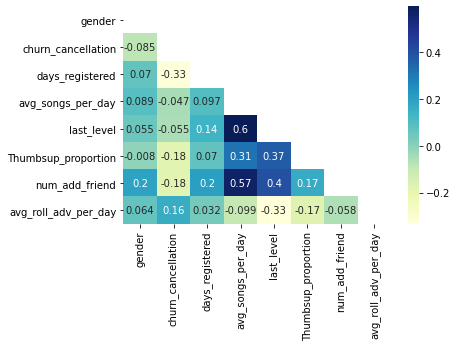

In [327]:
# Check correlation among features

# creating mask
mask = np.triu(np.ones_like(df_ml_pandas.corr()))
 
# plotting a triangle correlation heatmap
dataplot = sns.heatmap(df_ml_pandas.corr(), cmap="YlGnBu", annot=True, mask=mask)

# displaying heatmap
plt.show()

[Back to TOC](#Table-of-Contents:) 
<a class="anchor" id='chapter5'></a>

# Modeling

In this section, we follow the following steps: <br>
- Split the full dataset into train and test sets. 
- Test out several of the machine learning methods (Logistic Regression, Random Forest, Gradient-Boosting Tree). 
- Evaluate the accuracy of the various models, tuning parameters as necessary. 
- Determine the winning model based on test F1-score.

**Note on metrics:**<br>
Typically, when we look at the results of a classification model, we focus on the correct predictions of all the predictions made by the model, i.e., the accuracy of the model.<br>
In our case, when doing a **churn analysis with the goal of predicting customers who churned**, we are particularly interested in **having a lot of true positives**. However, since there are many customers who have not churned (**highly unbalanced datasets**), **the higher the number of true negatives the higher the accuracy**, which can be misleading. Thus, a **better measure of model performance in this case is the F1 score**, which is the harmonic mean of Precision ('out of all customers who were labeled as "churned," how many did we correctly label as such?') and Recall ('out of all customers who were labeled as "churned," how many actually churned?').

In [10]:
# Model Evaluator User Defined Functions
def udfModelEvaluator(dfPredictions, labelColumn='label'):

    colSelect = dfPredictions.select(
      [F.col('prediction').cast(DoubleType())
       ,F.col(labelColumn).cast(DoubleType()).alias('label')])

    metrics = MulticlassMetrics(colSelect.rdd)

    mMatrix = metrics.confusionMatrix().toArray().astype(int)    

    mTP = metrics.confusionMatrix().toArray()[1][1]
    mTN = metrics.confusionMatrix().toArray()[0][0]
    mFP = metrics.confusionMatrix().toArray()[0][1]
    mFN = metrics.confusionMatrix().toArray()[1][0]
    
    mAccuracy = metrics.accuracy
    mPrecision = mTP / (mTP + mFP)
    mRecall = mTP / (mTP + mFN)
    mF1 = metrics.fMeasure(1.0)

    mResults = [mAccuracy, mPrecision, mRecall, mF1, mMatrix, mTP, mTN, mFP, mFN, "Return [[0]=Accuracy, [1]=Precision, [2]=Recall, [3]=F1, [4]=ConfusionMatrix, [5]=TP, [6]=TN, [7]=FP, [8]=FN]"]

    return mResults

<a class="anchor" id='section5.1'></a>
### Split into Train and Test

In [11]:
# split into train and test sets (80% - 20%)

df_ml = df_ml.withColumnRenamed("churn_cancellation", "label")

train, test = df_ml.randomSplit([0.8, 0.2], seed = 42)


In [12]:
# Count users by label in train set

counts_train = train.groupBy('label').count().toPandas()
print(counts_train)

   label  count
0      0    137
1      1     43


In [13]:
# Counts

count_churned = counts_train[counts_train['label']==1]['count'].values[0]
count_total = counts_train['count'].sum()

# Weights

c = 2 # number of labels
weight_churned = count_total / (c * count_churned)
weight_no_churned = count_total / (c * (count_total - count_churned))

In [14]:
# Create a new column 'weight' containing a weight for each observation according to its class (i.e. churned / not churned)

train = train.withColumn("weight", when(train.label ==1, weight_churned).otherwise(weight_no_churned))
train.select('label', 'weight').where(train.label ==1).show(3)

+-----+------------------+
|label|            weight|
+-----+------------------+
|    1|2.0930232558139537|
|    1|2.0930232558139537|
|    1|2.0930232558139537|
+-----+------------------+
only showing top 3 rows



<a class="anchor" id='section5.2'></a>
### Machine Learning Pipelines

In [15]:
# Index and encode categorical feature 'last_state'
stringIndexerState = StringIndexer(inputCol="last_state", 
                                   outputCol="stateIndex", 
                                   handleInvalid = 'skip')

encoder = OneHotEncoder(inputCols=["stateIndex"],
                        outputCols=["stateVec"],
                        handleInvalid = 'keep')

# Create a vector for features to be used in the models
features = ['stateVec', 'gender', 'days_registered', 'avg_songs_per_day', 'last_level', 'Thumbsup_proportion', 'num_add_friend', 'avg_roll_adv_per_day']

# Merge multiple columns into a vector column
assemblers = VectorAssembler(inputCols=features, outputCol="rawFeatures")

# Scale features
scalers = MinMaxScaler(inputCol="rawFeatures", outputCol='features')

[Back to TOC](#Table-of-Contents:) 
<a class="anchor" id='section5.3'></a>

### Logistic Regression Classifier

In [334]:
# Initialize Logistic Regression Classifier
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

# Assemble pipeline
pipeline_lr = Pipeline(stages=[stringIndexerState, encoder, assemblers, scalers, lr])

In [335]:
model_lr = pipeline_lr.fit(train)

In [336]:
pred_train_lr = model_lr.transform(train)
pred_test_lr = model_lr.transform(test)

Metrics Train set:
 
Accuracy: 0.7611111111111111
Precision: nan
Recall: 0.0
F1-score: 0.0
 


/var/folders/8r/0dc1hj493qndcp189v0654jc0000gp/T/ipykernel_26408/110085937.py:18: RuntimeWarning:

invalid value encountered in double_scalars



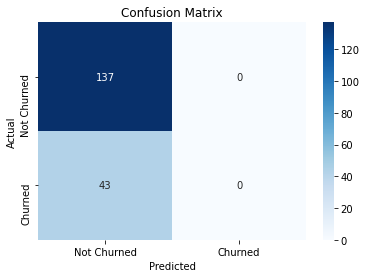

In [337]:
predictionAndLabels = pred_train_lr.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_train_lr = udfModelEvaluator(predictionAndLabels, "label")

print('Metrics Train set:')
print(' ')
print(f'Accuracy: {metricsList_train_lr[0]}')
print(f'Precision: {metricsList_train_lr[1]}')
print(f'Recall: {metricsList_train_lr[2]}')
print(f'F1-score: {metricsList_train_lr[3]}')
print(' ')


ax= plt.subplot()
sns.heatmap(metricsList_train_lr[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

Metrics Test set:
 
Accuracy: 0.8181818181818182
Precision: nan
Recall: 0.0
F1-score: 0.0
 


/var/folders/8r/0dc1hj493qndcp189v0654jc0000gp/T/ipykernel_26408/110085937.py:18: RuntimeWarning:

invalid value encountered in double_scalars



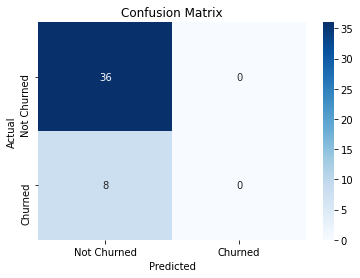

In [338]:
predictionAndLabels = pred_test_lr.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_test_lr = udfModelEvaluator(predictionAndLabels, "label")

print('Metrics Test set:')
print(' ')
print(f'Accuracy: {metricsList_test_lr[0]}')
print(f'Precision: {metricsList_test_lr[1]}')
print(f'Recall: {metricsList_test_lr[2]}')
print(f'F1-score: {metricsList_test_lr[3]}')
print(' ')


ax= plt.subplot()
sns.heatmap(metricsList_test_lr[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

#### Cross Validation and Parameter Tuning

In [339]:
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 30, 50]) \
    .addGrid(lr.regParam, [0.1, 0.3]) \
    .addGrid(lr.elasticNetParam, [0.8])\
    .addGrid(lr.family, ['auto'])\
    .build()

In [340]:
crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [341]:
#cvModel_lr = crossval_lr.fit(train)

In [342]:
# Save model results
#cvModel_lr.save('./models_results/cvModel_lr.mdl')

In [31]:
# Upload model results

cvModel_lr_loaded = CrossValidatorModel.load('./models_results/cvModel_lr.mdl')

In [32]:
bestModel_lr = cvModel_lr_loaded.bestModel

In [33]:
pred_train_best_lr = bestModel_lr.transform(train)
pred_test_best_lr = bestModel_lr.transform(test)

Metrics Train set:
 
Accuracy: 0.7611111111111111
Precision: nan
Recall: 0.0
F1-score: 0.0
 


/var/folders/8r/0dc1hj493qndcp189v0654jc0000gp/T/ipykernel_29274/110085937.py:18: RuntimeWarning: invalid value encountered in double_scalars
  mPrecision = mTP / (mTP + mFP)


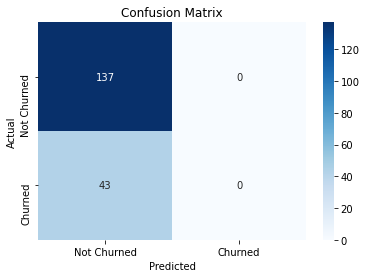

In [34]:
predictionAndLabels = pred_train_best_lr.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_train_best_lr = udfModelEvaluator(predictionAndLabels, "label")

print('Metrics Train set:')
print(' ')
print(f'Accuracy: {metricsList_train_best_lr[0]}')
print(f'Precision: {metricsList_train_best_lr[1]}')
print(f'Recall: {metricsList_train_best_lr[2]}')
print(f'F1-score: {metricsList_train_best_lr[3]}')
print(' ')


ax= plt.subplot()
sns.heatmap(metricsList_train_best_lr[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()


Metrics Test set:
 
Accuracy: 0.8181818181818182
Precision: nan
Recall: 0.0
F1-score: 0.0
 


/var/folders/8r/0dc1hj493qndcp189v0654jc0000gp/T/ipykernel_29274/110085937.py:18: RuntimeWarning: invalid value encountered in double_scalars
  mPrecision = mTP / (mTP + mFP)


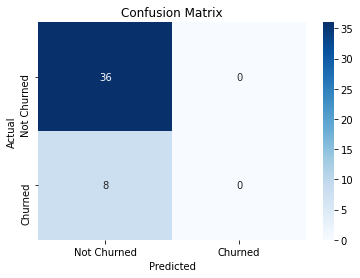

In [35]:
predictionAndLabels = pred_test_best_lr.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_test_best_lr = udfModelEvaluator(predictionAndLabels, "label")

print('Metrics Test set:')
print(' ')
print(f'Accuracy: {metricsList_test_best_lr[0]}')
print(f'Precision: {metricsList_test_best_lr[1]}')
print(f'Recall: {metricsList_test_best_lr[2]}')
print(f'F1-score: {metricsList_test_best_lr[3]}')
print(' ')


ax= plt.subplot()
sns.heatmap(metricsList_test_best_lr[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

In [349]:
# Get the results of cross validation

# get parameters
params = [{p.name: v for p, v in m.items()} for m in cvModel_lr.getEstimatorParamMaps()]

# Convert validation results to pandas dataframe
validation_results_lr = pd.DataFrame.from_dict([
    {cvModel_lr.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cvModel_lr.avgMetrics)
])

In [350]:
validation_results_lr

,f1,maxIter,regParam,elasticNetParam,family
0,0.649527,10,0.1,0.8,auto
1,0.652730,10,0.3,0.8,auto
2,0.649527,30,0.1,0.8,auto
3,0.652730,30,0.3,0.8,auto
4,0.649527,50,0.1,0.8,auto
5,0.652730,50,0.3,0.8,auto


[Back to TOC](#Table-of-Contents:) 

### Logistic Regression Classifier with Weights

In [351]:
# Initialize Logistic Regression Classifier
lr_weighted = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial", weightCol="weight")

# Assemble pipeline
pipeline_lr_weighted = Pipeline(stages=[stringIndexerState, encoder, assemblers, scalers, lr_weighted])

#### Cross Validation and Parameter Tuning

In [352]:
paramGrid_lr_weighted = ParamGridBuilder() \
    .addGrid(lr_weighted.maxIter, [10, 30, 50]) \
    .addGrid(lr_weighted.regParam, [0.1, 0.3]) \
    .addGrid(lr_weighted.elasticNetParam, [0.8])\
    .addGrid(lr_weighted.family, ['auto'])\
    .build()

In [353]:
crossval_lr_weighted = CrossValidator(estimator=pipeline_lr_weighted,
                          estimatorParamMaps=paramGrid_lr_weighted,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [354]:
#cvModel_lr_weighted = crossval_lr_weighted.fit(train)

In [355]:
# Save model results

#cvModel_lr_weighted.save('./models_results/cvModel_lr_weighted.mdl')

In [36]:
# Upload model results

cvModel_lr_weighted_loaded = CrossValidatorModel.load('./models_results/cvModel_lr_weighted.mdl')

In [38]:
bestModel_lr_weighted = cvModel_lr_weighted_loaded.bestModel

In [39]:
pred_train_best_lr_w = bestModel_lr_weighted.transform(train)
pred_test_best_lr_w = bestModel_lr_weighted.transform(test)

Metrics Train set:
 
Accuracy: 0.6833333333333333
Precision: 0.41025641025641024
Recall: 0.7441860465116279
F1-score: 0.5289256198347108
 


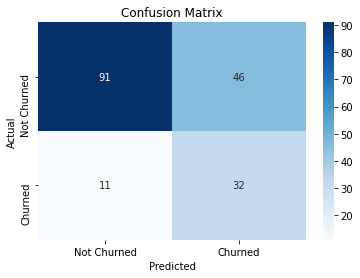

In [40]:
predictionAndLabels = pred_train_best_lr_w.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_train_best_lr_w = udfModelEvaluator(predictionAndLabels, "label")

print('Metrics Train set:')
print(' ')
print(f'Accuracy: {metricsList_train_best_lr_w[0]}')
print(f'Precision: {metricsList_train_best_lr_w[1]}')
print(f'Recall: {metricsList_train_best_lr_w[2]}')
print(f'F1-score: {metricsList_train_best_lr_w[3]}')
print(' ')


ax= plt.subplot()
sns.heatmap(metricsList_train_best_lr_w[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()


Metrics Test set:
 
Accuracy: 0.5227272727272727
Precision: 0.19047619047619047
Recall: 0.5
F1-score: 0.27586206896551724
 


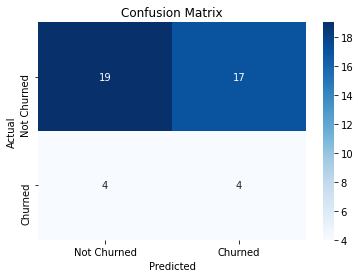

In [41]:
predictionAndLabels = pred_test_best_lr_w.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_test_best_lr_w = udfModelEvaluator(predictionAndLabels, "label")

print('Metrics Test set:')
print(' ')
print(f'Accuracy: {metricsList_test_best_lr_w[0]}')
print(f'Precision: {metricsList_test_best_lr_w[1]}')
print(f'Recall: {metricsList_test_best_lr_w[2]}')
print(f'F1-score: {metricsList_test_best_lr_w[3]}')
print(' ')


ax= plt.subplot()
sns.heatmap(metricsList_test_best_lr_w[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

In [361]:
# Get the results of cross validation

# get parameters
params = [{p.name: v for p, v in m.items()} for m in cvModel_lr_weighted.getEstimatorParamMaps()]

# Convert validation results to pandas dataframe
validation_results_lr_weighted = pd.DataFrame.from_dict([
    {cvModel_lr_weighted.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cvModel_lr_weighted.avgMetrics)
])

In [362]:
validation_results_lr_weighted

,f1,maxIter,regParam,elasticNetParam,family
0,0.681586,10,0.1,0.8,auto
1,0.231402,10,0.3,0.8,auto
2,0.706488,30,0.1,0.8,auto
3,0.231402,30,0.3,0.8,auto
4,0.706488,50,0.1,0.8,auto
5,0.231402,50,0.3,0.8,auto


[Back to TOC](#Table-of-Contents:) 
<a class="anchor" id='section5.4'></a>

### Random Forest Classifier

In [16]:
# Initialize Random Forest Classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

# Assemble pipeline
pipeline_rf = Pipeline(stages=[stringIndexerState, encoder, assemblers, scalers, rf])

In [26]:
model_rf = pipeline_rf.fit(train)

In [27]:
pred_train_rf = model_rf.transform(train)
pred_test_rf = model_rf.transform(test)

Metrics Train set:
 
Accuracy: 0.8722222222222222
Precision: 1.0
Recall: 0.46511627906976744
F1-score: 0.6349206349206349
 


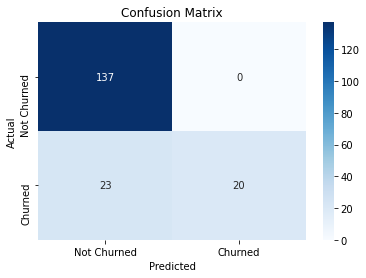

In [28]:
predictionAndLabels = pred_train_rf.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_train_rf = udfModelEvaluator(predictionAndLabels, "label")

print('Metrics Train set:')
print(' ')
print(f'Accuracy: {metricsList_train_rf[0]}')
print(f'Precision: {metricsList_train_rf[1]}')
print(f'Recall: {metricsList_train_rf[2]}')
print(f'F1-score: {metricsList_train_rf[3]}')
print(' ')


ax= plt.subplot()
sns.heatmap(metricsList_train_rf[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()


Metrics Test set:
 
Accuracy: 0.75
Precision: 0.2857142857142857
Recall: 0.25
F1-score: 0.26666666666666666
 


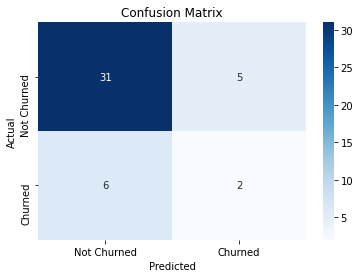

In [29]:
predictionAndLabels = pred_test_rf.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_test_rf = udfModelEvaluator(predictionAndLabels, "label")

print('Metrics Test set:')
print(' ')
print(f'Accuracy: {metricsList_test_rf[0]}')
print(f'Precision: {metricsList_test_rf[1]}')
print(f'Recall: {metricsList_test_rf[2]}')
print(f'F1-score: {metricsList_test_rf[3]}')
print(' ')


ax= plt.subplot()
sns.heatmap(metricsList_test_rf[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

#### Cross Validation and Parameters Tuning

In [17]:
# Create ParamGrid for Cross Validation
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30, 50, 100]) \
    .addGrid(rf.maxDepth, [3, 4, 5]) \
    .addGrid(rf.impurity, ['entropy', 'gini'])\
    .build()

In [18]:
crossval_rf = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [19]:
#cvModel_rf = crossval_rf.fit(train)

In [25]:
# Save model results


#cvModel_rf.save('./models_results/cvModel_rf.mdl')

In [42]:
# Upload model results

cvModel_rf_loaded = CrossValidatorModel.load('./models_results/cvModel_rf.mdl')

In [43]:
bestModel_rf = cvModel_rf_loaded.bestModel

In [44]:
pred_train_best_rf = bestModel_rf.transform(train)
pred_test_best_rf = bestModel_rf.transform(test)

Metrics Train set:
 
Accuracy: 0.8944444444444445
Precision: 1.0
Recall: 0.5581395348837209
F1-score: 0.7164179104477612
 


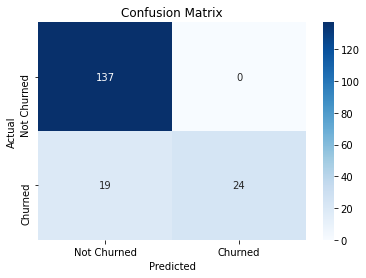

In [45]:
predictionAndLabels = pred_train_best_rf.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_train_best_rf = udfModelEvaluator(predictionAndLabels, "label")

print('Metrics Train set:')
print(' ')
print(f'Accuracy: {metricsList_train_best_rf[0]}')
print(f'Precision: {metricsList_train_best_rf[1]}')
print(f'Recall: {metricsList_train_best_rf[2]}')
print(f'F1-score: {metricsList_train_best_rf[3]}')
print(' ')


ax= plt.subplot()
sns.heatmap(metricsList_train_best_rf[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()


Metrics Test set:
 
Accuracy: 0.8181818181818182
Precision: 0.5
Recall: 0.25
F1-score: 0.3333333333333333
 


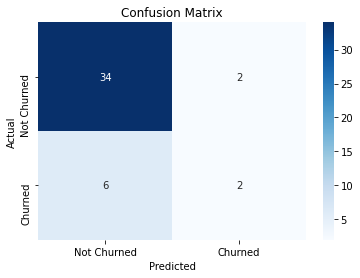

In [46]:
predictionAndLabels = pred_test_best_rf.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_test_best_rf = udfModelEvaluator(predictionAndLabels, "label")

print('Metrics Test set:')
print(' ')
print(f'Accuracy: {metricsList_test_best_rf[0]}')
print(f'Precision: {metricsList_test_best_rf[1]}')
print(f'Recall: {metricsList_test_best_rf[2]}')
print(f'F1-score: {metricsList_test_best_rf[3]}')
print(' ')


ax= plt.subplot()
sns.heatmap(metricsList_test_best_rf[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

Text(0.5, 1.0, 'Feature Importance')

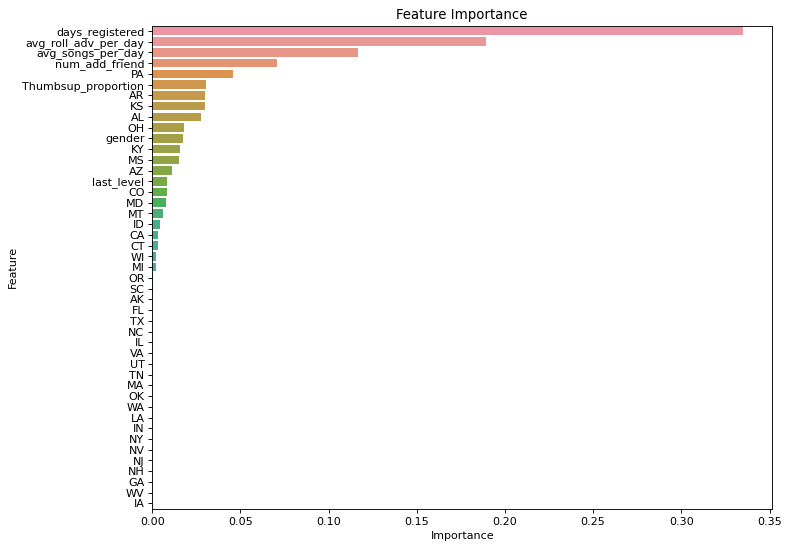

In [376]:
bestModel = bestModel_rf.stages[4]
importances = bestModel.featureImportances.toArray()
x_values = list(range(len(importances)))

# Retrieve features' labels
features_sel = ['gender', 'days_registered', 'avg_songs_per_day', 'last_level', 'Thumbsup_proportion', 'num_add_friend', 'avg_roll_adv_per_day']
features_states = bestModel_rf.stages[0].labels
features_labels = features_states + features_sel
feature_coef_df = pd.DataFrame(list(zip(features_labels, importances)), columns=['Feature', 'Importance'])\
    .sort_values('Importance', ascending=False)

# Plot the feature importance of the best model
plt.figure(figsize=(10, 8), dpi=80)

sns.barplot(x='Importance', y='Feature', data=feature_coef_df, orient = 'h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

In [377]:
# Check the parameters of the best model
bestModel = bestModel_rf.stages[4]
print('numTrees - ', bestModel.getNumTrees)
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))
print('impurity - ', bestModel.getOrDefault('impurity'))

numTrees -  10
maxDepth -  5
impurity -  gini


In [378]:
# Get the results of cross validation

# get parameters
params = [{p.name: v for p, v in m.items()} for m in cvModel_rf.getEstimatorParamMaps()]

# Convert validation results to pandas dataframe
validation_results_rf = pd.DataFrame.from_dict([
    {cvModel_rf.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cvModel_rf.avgMetrics)
])

In [379]:
validation_results_rf

,f1,numTrees,maxDepth,impurity
0,0.661881,10,3,entropy
1,0.674118,10,3,gini
2,0.712410,10,4,entropy
3,0.750892,10,4,gini
4,0.733926,10,5,entropy
5,0.768095,10,5,gini
6,0.665404,20,3,entropy
7,0.699887,20,3,gini
8,0.697862,20,4,entropy
9,0.720352,20,4,gini


[Back to TOC](#Table-of-Contents:) 

### Random Forest Classifier with weights

In [381]:
# Initialize Random Forest Classifier
rf_weighted = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10, weightCol="weight")

# Assemble pipeline
pipeline_rf_weighted = Pipeline(stages=[stringIndexerState, encoder, assemblers, scalers, rf_weighted])

#### Cross Validation and Parameters Tuning

In [382]:
# Create ParamGrid for Cross Validation
paramGrid_rf_weighted = ParamGridBuilder() \
    .addGrid(rf_weighted.numTrees, [10, 20, 30, 50, 100]) \
    .addGrid(rf_weighted.maxDepth, [3, 4, 5]) \
    .addGrid(rf_weighted.impurity, ['entropy', 'gini'])\
    .build()

In [383]:
crossval_rf_weighted = CrossValidator(estimator=pipeline_rf_weighted,
                          estimatorParamMaps=paramGrid_rf_weighted,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [384]:
#cvModel_rf_weighted = crossval_rf_weighted.fit(train)

In [385]:
# Save model results

#cvModel_rf_weighted.save('./models_results/cvModel_rf_weighted.mdl')

In [47]:
# Upload model results

cvModel_rf_weighted_loaded = CrossValidatorModel.load('./models_results/cvModel_rf_weighted.mdl')

In [48]:
bestModel_rf_weighted = cvModel_rf_weighted_loaded.bestModel

In [49]:
pred_train_best_rf_weighted = bestModel_rf_weighted.transform(train)
pred_test_best_rf_weighted = bestModel_rf_weighted.transform(test)

Metrics Train set:
 
Accuracy: 0.8
Precision: 0.5660377358490566
Recall: 0.6976744186046512
F1-score: 0.625
 


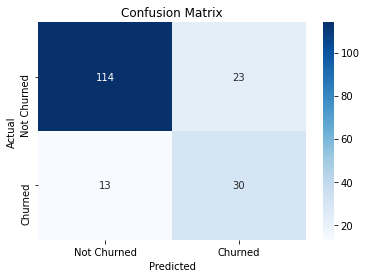

In [50]:
predictionAndLabels = pred_train_best_rf_weighted.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_train_best_rf_w = udfModelEvaluator(predictionAndLabels, "label")

print('Metrics Train set:')
print(' ')
print(f'Accuracy: {metricsList_train_best_rf_w[0]}')
print(f'Precision: {metricsList_train_best_rf_w[1]}')
print(f'Recall: {metricsList_train_best_rf_w[2]}')
print(f'F1-score: {metricsList_train_best_rf_w[3]}')
print(' ')


ax= plt.subplot()
sns.heatmap(metricsList_train_best_rf_w[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()


Metrics Test set:
 
Accuracy: 0.7045454545454546
Precision: 0.2222222222222222
Recall: 0.25
F1-score: 0.23529411764705882
 


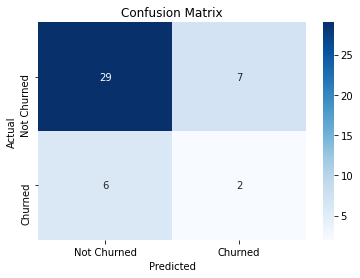

In [51]:
predictionAndLabels = pred_test_best_rf_weighted.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_test_best_rf_w = udfModelEvaluator(predictionAndLabels, "label")

print('Metrics Test set:')
print(' ')
print(f'Accuracy: {metricsList_test_best_rf_w[0]}')
print(f'Precision: {metricsList_test_best_rf_w[1]}')
print(f'Recall: {metricsList_test_best_rf_w[2]}')
print(f'F1-score: {metricsList_test_best_rf_w[3]}')
print(' ')


ax= plt.subplot()
sns.heatmap(metricsList_test_best_rf_w[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

[Back to TOC](#Table-of-Contents:)

<a class="anchor" id='section5.5'></a>

### Gradient-Boosted Tree Classifier

In [396]:
# Initialize Gradient-Boosting Tree Classifier
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

# Assemble pipeline
pipeline_gbt = Pipeline(stages = [stringIndexerState, encoder, assemblers, scalers, gbt])

In [42]:
model_gbt = pipeline_gbt.fit(train)

In [43]:
pred_train_gbt = model_gbt.transform(train)
pred_test_gbt = model_gbt.transform(test)

Metrics Train set:
 
Accuracy: 0.9777777777777777
Precision: 1.0
Recall: 0.9069767441860465
F1-score: 0.951219512195122
 


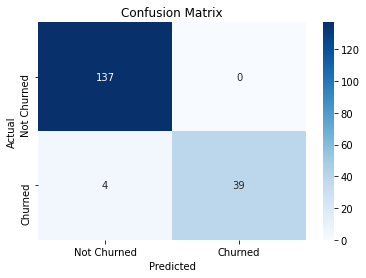

In [44]:
predictionAndLabels = pred_train_gbt.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_train_gbt = udfModelEvaluator(predictionAndLabels, "label")

print('Metrics Train set:')
print(' ')
print(f'Accuracy: {metricsList_train_gbt[0]}')
print(f'Precision: {metricsList_train_gbt[1]}')
print(f'Recall: {metricsList_train_gbt[2]}')
print(f'F1-score: {metricsList_train_gbt[3]}')
print(' ')


ax= plt.subplot()
sns.heatmap(metricsList_train_gbt[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

Metrics Test set:
 
Accuracy: 0.75
Precision: 0.3333333333333333
Recall: 0.375
F1-score: 0.35294117647058826
 


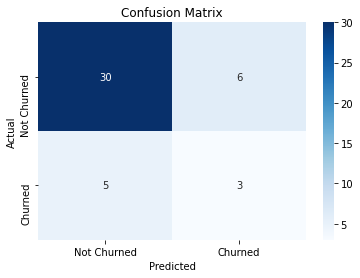

In [45]:
predictionAndLabels = pred_test_gbt.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_test_gbt = udfModelEvaluator(predictionAndLabels, "label")
metricsList_test_gbt

print('Metrics Test set:')
print(' ')
print(f'Accuracy: {metricsList_test_gbt[0]}')
print(f'Precision: {metricsList_test_gbt[1]}')
print(f'Recall: {metricsList_test_gbt[2]}')
print(f'F1-score: {metricsList_test_gbt[3]}')
print(' ')


ax= plt.subplot()
sns.heatmap(metricsList_test_gbt[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

#### Cross Validation and Parameter Tuning

In [397]:
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20, 40]) \
    .addGrid(gbt.maxDepth, [2, 3, 5]) \
    .build()

In [398]:
crossval_gbt = CrossValidator(estimator=pipeline_gbt,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [399]:
#cvModel_gbt = crossval_gbt.fit(train)

In [400]:
# Save model results

#cvModel_gbt.save('./models_results/cvModel_gbt.mdl')

In [52]:
# Upload model results

cvModel_gbt_loaded = CrossValidatorModel.load('./models_results/cvModel_gbt.mdl')


In [53]:
bestModel_gbt = cvModel_gbt_loaded.bestModel

In [54]:
pred_train_best_gbt = bestModel_gbt.transform(train)
pred_test_best_gbt = bestModel_gbt.transform(test)

21/11/02 18:32:58 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/11/02 18:32:58 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Metrics Train set:
 
Accuracy: 0.8944444444444445
Precision: 0.875
Recall: 0.6511627906976745
F1-score: 0.7466666666666667
 


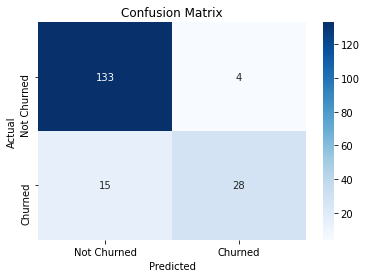

In [55]:
predictionAndLabels = pred_train_best_gbt.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_train_best_gbt = udfModelEvaluator(predictionAndLabels, "label")
metricsList_train_best_gbt

print('Metrics Train set:')
print(' ')
print(f'Accuracy: {metricsList_train_best_gbt[0]}')
print(f'Precision: {metricsList_train_best_gbt[1]}')
print(f'Recall: {metricsList_train_best_gbt[2]}')
print(f'F1-score: {metricsList_train_best_gbt[3]}')
print(' ')


ax= plt.subplot()
sns.heatmap(metricsList_train_best_gbt[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

Metrics Test set:
 
Accuracy: 0.75
Precision: 0.2857142857142857
Recall: 0.25
F1-score: 0.26666666666666666
 


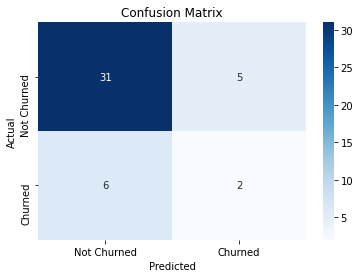

In [56]:
predictionAndLabels = pred_test_best_gbt.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_test_best_gbt = udfModelEvaluator(predictionAndLabels, "label")
metricsList_test_best_gbt

print('Metrics Test set:')
print(' ')
print(f'Accuracy: {metricsList_test_best_gbt[0]}')
print(f'Precision: {metricsList_test_best_gbt[1]}')
print(f'Recall: {metricsList_test_best_gbt[2]}')
print(f'F1-score: {metricsList_test_best_gbt[3]}')
print(' ')


ax= plt.subplot()
sns.heatmap(metricsList_test_best_gbt[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

Text(0.5, 1.0, 'Feature Importance')

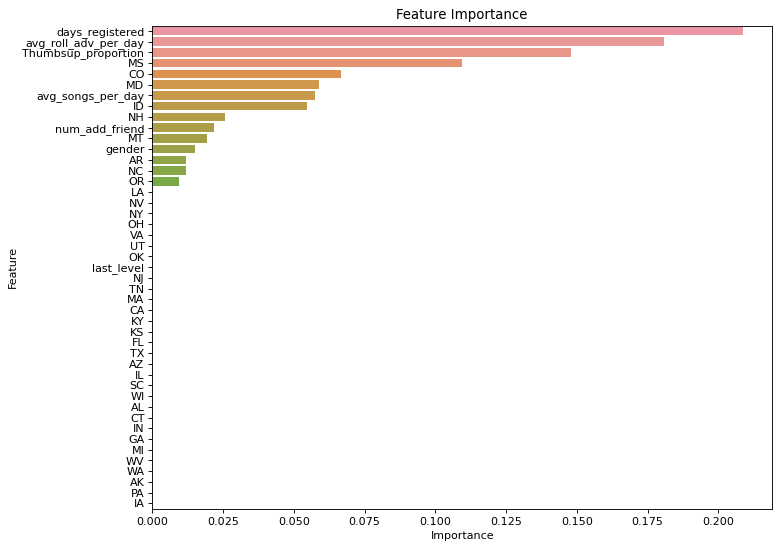

In [408]:
bestModel = bestModel_gbt.stages[4]
importances = bestModel.featureImportances.toArray()
x_values = list(range(len(importances)))

# Retrieve features' labels
features_sel = ['gender', 'days_registered', 'avg_songs_per_day', 'last_level', 'Thumbsup_proportion', 'num_add_friend', 'avg_roll_adv_per_day']
features_states = bestModel_gbt.stages[0].labels
features_labels = features_states + features_sel
feature_coef_df = pd.DataFrame(list(zip(features_labels, importances)), columns=['Feature', 'Importance'])\
    .sort_values('Importance', ascending=False)

# Plot the feature importance of the best model
plt.figure(figsize=(10, 8), dpi=80)

sns.barplot(x='Importance', y='Feature', data=feature_coef_df, orient = 'h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

In [409]:
# Get the results of cross validation

# get parameters
params = [{p.name: v for p, v in m.items()} for m in cvModel_gbt.getEstimatorParamMaps()]

# Convert validation results to pandas dataframe
validation_results_gbt = pd.DataFrame.from_dict([
    {cvModel_gbt.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cvModel_gbt.avgMetrics)
])

In [410]:
validation_results_gbt

,f1,maxIter,maxDepth
0,0.761805,10,2
1,0.760065,10,3
2,0.727771,10,5
3,0.783531,20,2
4,0.760065,20,3
5,0.732105,20,5
6,0.773224,40,2
7,0.766424,40,3
8,0.737940,40,5


[Back to TOC](#Table-of-Contents:) 

### Gradient-Boosted Tree Classifier with Weights

In [411]:
# Initialize Gradient-Boosting Tree Classifier
gbt_weighted = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10, weightCol="weight")

# Assemble pipeline
pipeline_gbt_weighted = Pipeline(stages = [stringIndexerState, encoder, assemblers, scalers, gbt_weighted])

#### Cross Validation and Parameter Tuning

In [412]:
paramGrid_gbt_weighted = ParamGridBuilder() \
    .addGrid(gbt_weighted.maxIter, [10, 20, 40]) \
    .addGrid(gbt_weighted.maxDepth, [2, 3, 5]) \
    .build()

In [413]:
crossval_gbt_weighted = CrossValidator(estimator=pipeline_gbt_weighted,
                          estimatorParamMaps=paramGrid_gbt_weighted,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [414]:
#cvModel_gbt_weighted = crossval_gbt_weighted.fit(train)

In [415]:
# Save model results

#cvModel_gbt_weighted.save('./models_results/cvModel_gbt_weighted.mdl')

In [63]:
# Upload model results

cvModel_gbt_weighted_loaded = CrossValidatorModel.load('./models_results/cvModel_gbt_weighted.mdl')

In [64]:
bestModel_gbt_weighted = cvModel_gbt_weighted_loaded.bestModel

In [65]:
pred_train_best_gbt_weighted = bestModel_gbt_weighted.transform(train)
pred_test_best_gbt_weighted = bestModel_gbt_weighted.transform(test)

Metrics Train set:
 
Accuracy: 0.9277777777777778
Precision: 0.8
Recall: 0.9302325581395349
F1-score: 0.8602150537634408
 


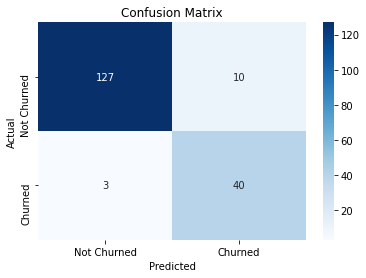

In [66]:
predictionAndLabels = pred_train_best_gbt_weighted.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_train_best_gbt_w = udfModelEvaluator(predictionAndLabels, "label")
metricsList_train_best_gbt_w

print('Metrics Train set:')
print(' ')
print(f'Accuracy: {metricsList_train_best_gbt_w[0]}')
print(f'Precision: {metricsList_train_best_gbt_w[1]}')
print(f'Recall: {metricsList_train_best_gbt_w[2]}')
print(f'F1-score: {metricsList_train_best_gbt_w[3]}')
print(' ')


ax= plt.subplot()
sns.heatmap(metricsList_train_best_gbt_w[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

Metrics Test set:
 
Accuracy: 0.7045454545454546
Precision: 0.2727272727272727
Recall: 0.375
F1-score: 0.3157894736842105
 


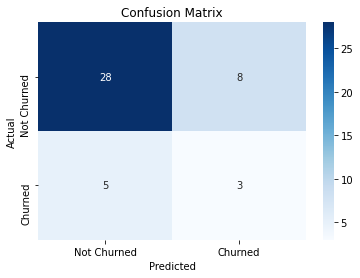

In [67]:
predictionAndLabels = pred_test_best_gbt_weighted.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_test_best_gbt_w = udfModelEvaluator(predictionAndLabels, "label")
metricsList_test_best_gbt_w

print('Metrics Test set:')
print(' ')
print(f'Accuracy: {metricsList_test_best_gbt_w[0]}')
print(f'Precision: {metricsList_test_best_gbt_w[1]}')
print(f'Recall: {metricsList_test_best_gbt_w[2]}')
print(f'F1-score: {metricsList_test_best_gbt_w[3]}')
print(' ')


ax= plt.subplot()
sns.heatmap(metricsList_test_best_gbt_w[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

[Back to TOC](#Table-of-Contents:) 
<a class="anchor" id='section5.7'></a>

### Models Comparison

In [68]:
# Assemble the results of F1 score for each model in a dataframe
res = [{'Classifier': 'Logistic Regression', 'Accuracy': metricsList_train_best_lr[0], 'Train - F1 score': metricsList_train_best_lr[3], 'Test - F1 score': metricsList_test_best_lr[3]},
       {'Classifier': 'Random Forest', 'Accuracy': metricsList_train_best_rf[0], 'Train - F1 score': metricsList_train_best_rf[3], 'Test - F1 score': metricsList_test_best_rf[3]},
       {'Classifier': 'Gradient-boosted Tree', 'Accuracy': metricsList_train_best_gbt[0], 'Train - F1 score': metricsList_train_best_gbt[3], 'Test - F1 score': metricsList_test_best_gbt[3]},
       {'Classifier': 'Logistic Regression with weights', 'Accuracy': metricsList_train_best_lr_w[0], 'Train - F1 score': metricsList_train_best_lr_w[3], 'Test - F1 score': metricsList_test_best_lr_w[3]},
       {'Classifier': 'Random Forest with weights', 'Accuracy':  metricsList_train_best_rf_w[0], 'Train - F1 score': metricsList_train_best_rf_w[3], 'Test - F1 score': metricsList_test_best_rf_w[3]},
       {'Classifier': 'Gradient-boosted Tree with weights', 'Accuracy': metricsList_train_best_gbt_w[0], 'Train - F1 score': metricsList_train_best_gbt_w[3], 'Test - F1 score': metricsList_test_best_gbt_w[3]}]


results = pd.DataFrame(res)


results

,Classifier,Accuracy,Train - F1 score,Test - F1 score
0,Logistic Regression,0.761111,0.000000,0.000000
1,Random Forest,0.894444,0.716418,0.333333
2,Gradient-boosted Tree,0.894444,0.746667,0.266667
3,Logistic Regression with weights,0.683333,0.528926,0.275862
4,Random Forest with weights,0.800000,0.625000,0.235294
5,Gradient-boosted Tree with weights,0.927778,0.860215,0.315789


21/11/03 01:36:29 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 2138562 ms exceeds timeout 120000 ms
21/11/03 01:36:29 WARN SparkContext: Killing executors is not supported by current scheduler.


Comparing the performance of different classifiers, we observe that: <br>
- Logistic regression performed poorly especially in predicting true positives (users who churned). Performance improves by adding label weights to account for the highly imbalanced dataset.
- Random Forest and Gradient-boosted tree with weights are the best perfomers especially when we look at the F1 score on the test set. The results are encouraging, yet not completely satisfying.
We'll explore their robustness on the full dataset using AWS clusters.


<a class="anchor" id='chapter6'></a>
## Conclusions

We built an **ML pipeline to predict user churn** that consists of: <br>

- String indexer and encoder for categorical features.
- Features assembler.
- Scaler: we use MinMaxScaler() which transforms each column value into the range [0,1], preserving the shape of the data.
- Classifiers: Logistic Regression, Random Forest, Gradient-Boosting Tree.

For all classification models, we used **hyperparameter tuning and cross-validation**.

The **best performing model** according to the **F1 score** in the test set is the **gradient-boosted tree classifier** where **label weights** were included in the model **to account for the highly imbalanced dataset**. In fact, **the number of active users is more than three times the number of unsubscribed users**.  



<a class="anchor" id='section6.1'></a>
### Future further improvements

To improve the performance of the most promising models we can: <br>
- Use a larger dataset. Having more data can increase the robustness of the model.
- Spend more time engineering features by trying to think of more meaningful features (e.g., sequence of events that precede user's churn).
- Do more tuning of hyperparameters.
- Perform stacking of models.
- Find a better approach to dealing with strongly imbalanced data.

[Back to TOC](#Table-of-Contents:) 